This Notebook aims to combine all necessary steps for each model of the shrinkage methods.

" Question:
Are the following models all shrinkage methods?

Answer:
1. Linear Regression: 
Linear regression is not inherently a shrinkage method. It aims to fit a linear relationship between the input features and the target variable by minimizing the sum of squared residuals. However, it can be considered a baseline model against which shrinkage methods are compared.
2. Ridge Regression: 
Ridge regression is a shrinkage method that adds an L2 regularization term to the linear regression objective function. The L2 regularization term penalizes large coefficient values and helps reduce the impact of multicollinearity by shrinking the coefficients towards zero.
3. Elastic Net Regression: 
Elastic Net regression is a combination of Ridge regression and Lasso regression. It adds both L1 (Lasso) and L2 (Ridge) regularization terms to the linear regression objective function. The L1 regularization promotes sparsity by driving some coefficients to exactly zero, while the L2 regularization helps handle multicollinearity.
4. Bridge Regression: 
Bridge regression, also known as the Bayesian Bridge regression, is a variant of Ridge regression that introduces a hyperparameter to control the trade-off between the L1 and L2 regularization terms. By adjusting this hyperparameter, bridge regression can smoothly transition between Ridge regression (L2 regularization) and Lasso regression (L1 regularization).
5. Lasso Regression: 
Lasso regression, short for Least Absolute Shrinkage and Selection Operator, is a shrinkage method that adds an L1 regularization term to the linear regression objective function. The L1 regularization promotes sparsity by driving some coefficients to exactly zero, effectively performing feature selection and shrinking less important features.

In summary, Ridge regression, Elastic Net regression, Bridge regression, and Lasso regression are all shrinkage methods that introduce regularization terms to the linear regression objective function. These regularization terms help control the complexity of the model and can lead to improved performance, feature selection, and handling of multicollinearity."

In [133]:
# first import the libraries
import pandas as pd
import numpy as np
from darts import TimeSeries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from darts.models import LinearRegressionModel, RegressionModel, RandomForest, RegressionEnsembleModel
from sklearn import cross_decomposition
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from darts.metrics import mape, r2_score, mse, mae
import sklearn
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, plotting, EfficientFrontier
import copy


import warnings

In [3]:
# Filter out the FutureWarning message
warnings.filterwarnings("ignore", category=(FutureWarning))
warnings.filterwarnings("ignore", category=(UserWarning))
# get rid of the LinAlgWarning message
#from numpy.linalg import LinAlgWarning
#warnings.filterwarnings('ignore', category=LinAlgWarning)

In [4]:
# load the data, use Darts TimeSeries
ts = TimeSeries.from_csv('data/price_data_filtered.csv', parse_dates=True, index_col=0)

In [5]:
# compute monthly returns using pandas pct_change
returns = ts.pd_dataframe().pct_change().dropna()

Stored 'cum_returns' (DataFrame)


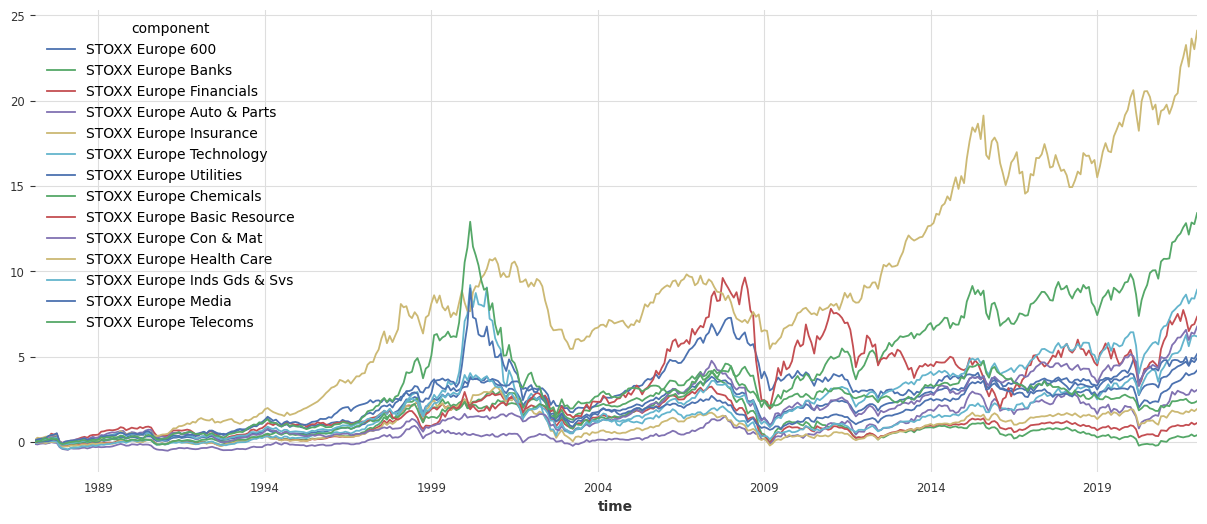

In [6]:
# compute the cumulative monthly returns
cum_returns = (1 + returns).cumprod() - 1

cum_returns_portfolio = cum_returns
# store the cum_returns to use it in another notebook
%store cum_returns

# plot the cumulative returns
fig, ax = plt.subplots(figsize=(15, 6))
cum_returns.plot(ax=ax);

In [7]:
# to use the Darts models, we need to convert the data to a Darts TimeSeries
cum_returns = TimeSeries.from_dataframe(df = cum_returns,time_col= 0, fill_missing_dates=True)

In [8]:
# split the data into training and test set, use 80% for training
train, test = cum_returns.split_after(0.8)

In [9]:
420/12

35.0

## Benchmark Portfolios

Our main benchmark is the STOXX Europe 600 Index. Furthermore, we expand the benchmarks by computing the equal weighted portfolio and portfolio based on historical averages.

### Equal Weighted Portfolio

In [10]:
# create a list of the column names
col_list = list(cum_returns.columns)[1:]

In [11]:
# create weights
weights_ew = 1/len(col_list)

In [12]:
# print single weight and the sum of all weights
print('The weight for each stock is: ' + str(weights_ew))
print('The sum of all weights is: ' + str(weights_ew * 13))

The weight for each stock is: 0.07692307692307693
The sum of all weights is: 1.0


In [13]:
# create a new column in cum_returns for the equal weighted portfolio
cum_returns_portfolio['equal_weighted'] = cum_returns_portfolio[col_list].mul(weights_ew).sum(axis=1)

In [14]:
# create a new variable called portfolio_returns with same structure as cum_returns
portfolio_returns = cum_returns_portfolio.copy()
# delete all columns except for the equal_weighted column
portfolio_returns.drop(cum_returns_portfolio.columns.difference(['equal_weighted']), 1, inplace=True)
portfolio_returns.tail()

component,equal_weighted
time,
2021-09-01,6.334322
2021-10-01,5.926514
2021-11-01,6.322933
2021-12-01,6.237121
2022-01-01,6.544394


In [15]:
# delete equal weighted column from cum_returns
cum_returns_portfolio.drop('equal_weighted', axis=1, inplace=True)

### Portfolio based on Historical Average

In [156]:
# Calculate average daily returns for each stock and exlude the first column
avg_returns = cum_returns_portfolio.mean()[1:]

# Calculate weights based on average daily returns
weights_ha = avg_returns / avg_returns.sum()

# Calculate portfolio returns
ha_returns = (cum_returns_portfolio * weights_ha).sum(axis=1)

# Add portfolio_returns as a new column in cum_returns
portfolio_returns['historical_average'] = ha_returns

# show the last 5 rows of portfolio_returns of historical average portfolio
portfolio_returns.tail()

component,equal_weighted,historical_average,Bayesian Regression,linear_regression_1,linear_regression_316,ridge_regression_1,ridge_regression_316,lasso_regression_1,lasso_regression_316,Elastic_Net_1,Elastic_Net_316,bridge_regression_1
time,,,,,,,,,,,,
2021-09-01,6.334322,10.565259,21.757793,16.437078,7.241788,23.264545,7.241703,21.147879,1.920520,21.147879,1.920520,22.959692
2021-10-01,5.926514,9.912039,20.570190,15.535738,6.504470,21.991305,6.504393,19.946396,1.875364,19.946396,1.875364,21.698781
2021-11-01,6.322933,10.583310,22.082632,16.719975,6.839192,23.637809,6.839111,21.427089,2.045217,21.427089,2.045217,23.323187
2021-12-01,6.237121,10.402550,21.532173,16.281709,6.914258,23.011935,6.914176,20.892168,1.949463,20.892168,1.949463,22.707336
2022-01-01,6.544394,10.913366,22.553606,17.049796,7.346731,24.096923,7.346643,21.880713,2.078423,21.880713,2.078423,23.780296


In [162]:
# show average return of health care
avg_returns

component
STOXX Europe Banks             1.062932
STOXX Europe Financials        0.987653
STOXX Europe Auto & Parts      0.702626
STOXX Europe Insurance         0.893093
STOXX Europe Technology        1.634406
STOXX Europe Utilities         2.763100
STOXX Europe Chemicals         3.495400
STOXX Europe Basic Resource    3.203787
STOXX Europe Con & Mat         1.987670
STOXX Europe Health Care       8.323560
STOXX Europe Inds Gds & Svs    2.477718
STOXX Europe Media             2.030860
STOXX Europe Telecoms          2.624212
dtype: float64

In [163]:
avg_returns['STOXX Europe Auto & Parts']/avg_returns.sum()

0.021829482191472144

In [17]:
# print single weight and the sum of all weights for historical average portfolio
print('The weight for each stock is: ' + str(weights_ha))
print('The sum of all weights is: ' + str(weights_ha.sum()))

The weight for each stock is: component
STOXX Europe Banks             0.033024
STOXX Europe Financials        0.030685
STOXX Europe Auto & Parts      0.021829
STOXX Europe Insurance         0.027747
STOXX Europe Technology        0.050778
STOXX Europe Utilities         0.085845
STOXX Europe Chemicals         0.108597
STOXX Europe Basic Resource    0.099537
STOXX Europe Con & Mat         0.061754
STOXX Europe Health Care       0.258600
STOXX Europe Inds Gds & Svs    0.076979
STOXX Europe Media             0.063096
STOXX Europe Telecoms          0.081530
dtype: float64
The sum of all weights is: 1.0


### Plotting benchmarks

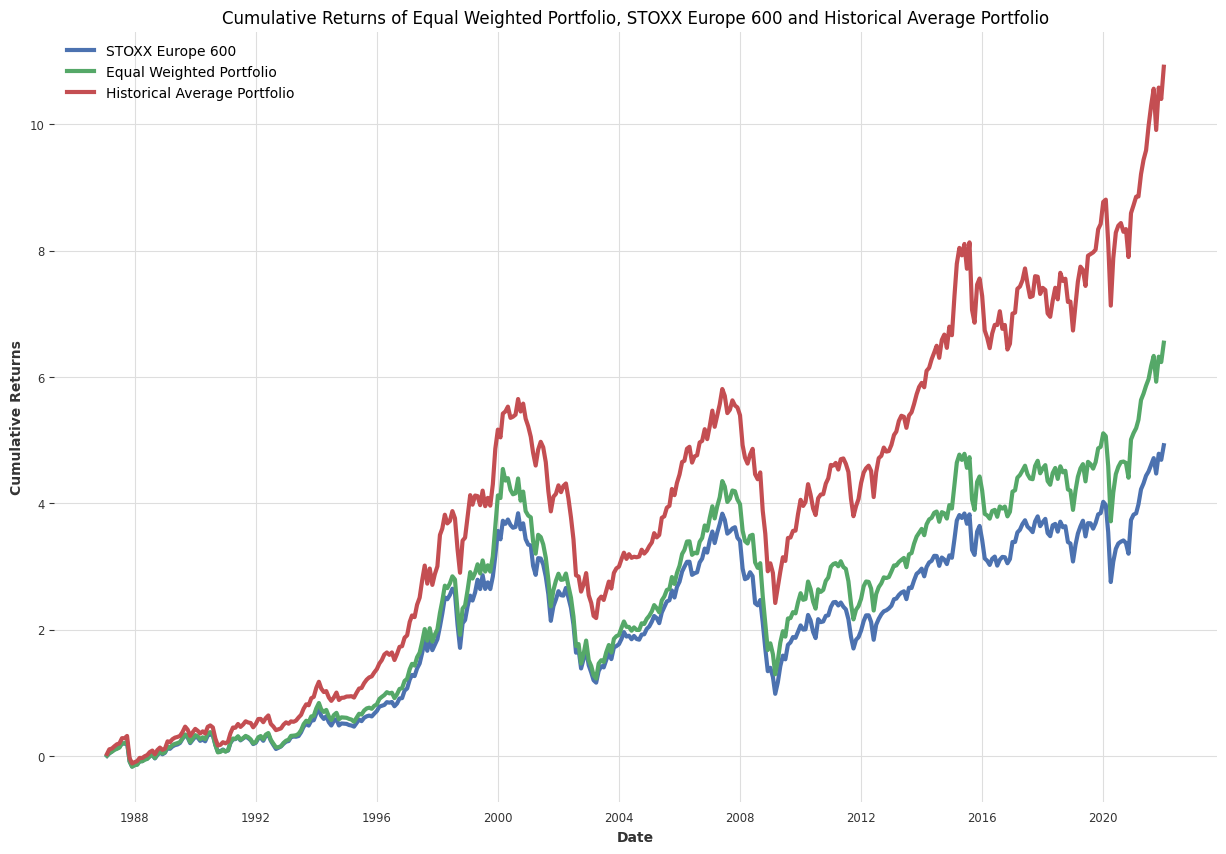

In [18]:
# plot the cumulative returns of the equal weighted portfolio, the STOXX Europe 600 and the historical average portfolio
plt.figure(figsize=(15,10))
plt.plot(cum_returns_portfolio['STOXX Europe 600'], label='STOXX Europe 600', lw=3)
plt.plot(portfolio_returns['equal_weighted'], label='Equal Weighted Portfolio', lw=3)
plt.plot(portfolio_returns['historical_average'], label='Historical Average Portfolio', lw=3)
plt.legend(loc='upper left')
plt.title('Cumulative Returns of Equal Weighted Portfolio, STOXX Europe 600 and Historical Average Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show();

In [19]:
# show only the last value of equal weighted portfolio, STOXX Europe 600 and historical average portfolio
print('The last value of the STOXX Europe 600 is: ' + str(round(cum_returns_portfolio.iloc[-1,0], 2)) + '%')
print('The last value of the equal weighted portfolio is: ' + str(round(portfolio_returns.iloc[-1,0], 2)) + '%') 
print('The last value of the historical average portfolio is: ' + str(round(portfolio_returns.iloc[-1,1], 2)) + '%')

The last value of the STOXX Europe 600 is: 4.92%
The last value of the equal weighted portfolio is: 6.54%
The last value of the historical average portfolio is: 10.91%


In [20]:
# show their respective volatility
print('The volatility of the STOXX Europe 600 is: ' + str(round(cum_returns_portfolio.iloc[:,0].std(), 2)) + '%')
print('The volatility of the equal weighted portfolio is: ' + str(round(portfolio_returns.iloc[:,0].std(), 2)) + '%')
print('The volatility of the historical average portfolio is: ' + str(round(portfolio_returns.iloc[:,1].std(), 2)) + '%')

The volatility of the STOXX Europe 600 is: 1.31%
The volatility of the equal weighted portfolio is: 1.63%
The volatility of the historical average portfolio is: 2.67%


In [21]:
def plot_efficient_frontier(mu, S, cum_returns_portfolio, title):
    ef = EfficientFrontier(mu, S)
    ef.add_constraint(lambda w: w[0] == 0.00)
    fig, ax = plt.subplots()
    ef_max_sharpe = ef.deepcopy()
    ef_min_vol = copy.deepcopy(ef)
    plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

    # Find the tangency portfolio with max Sharpe ratio
    ef_max_sharpe.max_sharpe()
    weights_max = ef_max_sharpe.clean_weights()
    ret_max = (cum_returns_portfolio * weights_max).sum(axis=1)
    std_max = ret_max.std()
    ax.scatter(std_max, ret_max.iloc[-1], marker="*", s=100, c="r", label="Max Sharpe")

    # Find the minimum volatility portfolio
    ef_min_vol.min_volatility()
    weights_min = ef_min_vol.clean_weights()
    ret_min = (cum_returns_portfolio * weights_min).sum(axis=1)
    std_min = ret_min.std()
    ax.scatter(std_min, ret_min.iloc[-1], marker="*", s=100, c="g", label="Min Volatility")    
    
    # compute the efficient frontier mathematically while using same optimization objective as the EfficientFrontier class without using pyportfolioopt
    """
    # Compute the efficient frontier
    """

    # save the return and volatility of max sharpe and min vola in two lists to a csv file naming them after mu

    
    
    # Generate random portfolios
    n_samples = 10000
    w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
    rets = w.dot(ef.expected_returns)
    stds = np.sqrt(np.diag(w @ S @ w.T))
    sharpes = rets / stds
    ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

    weights_max = pd.DataFrame.from_dict(weights_max, orient='index')
    weights_max.columns = ['Max Sharpe']
    weights_max = weights_max.T
    weights_min = pd.DataFrame.from_dict(weights_min, orient='index')
    weights_min.columns = ['Min Volatility']
    weights_min = weights_min.T
    
    
    # Generate a table with the weights of the max Sharpe ratio portfolio
    weights = pd.concat([weights_max, weights_min])
    # drop the rows with 0 weights in both portfolios
    weights = weights.loc[:, (weights != 0).any(axis=0)]
    # add a column that sums the weights per row
    weights['Sum'] = weights.sum(axis=1)

    # Display the clean table
    print("Weights:\n", weights.to_string(index=True, float_format='{:.2%}'.format))

    # Display the return and volatility of the max Sharpe ratio and min volatility portfolios
    performance = pd.DataFrame({"Return": [ret_max.iloc[-1]/100, ret_min.iloc[-1]/100],
                                "Volatility": [std_max/100, std_min/100]},
                               index=["Max Sharpe", "Min Volatility"])

    # Display the performance table
    print("\nPerformance:\n", performance.to_string(float_format='{:.2%}'.format))

    # Print table as LaTeX
    #print("\nWeights (LaTeX):\n", weights.transpose().to_latex(index=True, float_format='{:.2%}'.format))
    #print("\nPerformance (LaTeX):\n", performance.transpose().to_latex(float_format='{:.2%}'.format))

    # Output
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show();

In [22]:
def generate_pie_chart(weights, title):
    cleaned_weights = {k: v for k, v in weights.items() if v > 1e-5}

    plt.figure(figsize=(10, 5))
    # Generate the pie chart without labels inside the slices
    wedges, _, _ = plt.pie(cleaned_weights.values(), labels=[''] * len(cleaned_weights), autopct='%1.2f%%', startangle=90)

    # Create a legend with the cleaned weights keys
    plt.legend(wedges, cleaned_weights.keys(), loc='upper left')

    # Create a legend with the cleaned weights keys
    plt.legend(wedges, cleaned_weights.keys(), loc='upper left')# Equal aspect ratio ensures that pie is drawn as a circle.
    plt.axis('equal')
    plt.title(title)
    plt.show();

## Shrinkage Methods

### Bayesian Regression

In [23]:
bayesian_model_1 = RegressionModel(lags=1, model=sklearn.linear_model.BayesianRidge())
bayesian_model_1.fit(train)
bayesian_forecast_1 = bayesian_model_1.predict(len(test))

In [24]:
hf1_bayesian = bayesian_model_1.historical_forecasts(series=cum_returns, start=0.7, forecast_horizon=1, verbose=True)

  0%|          | 0/127 [00:00<?, ?it/s]

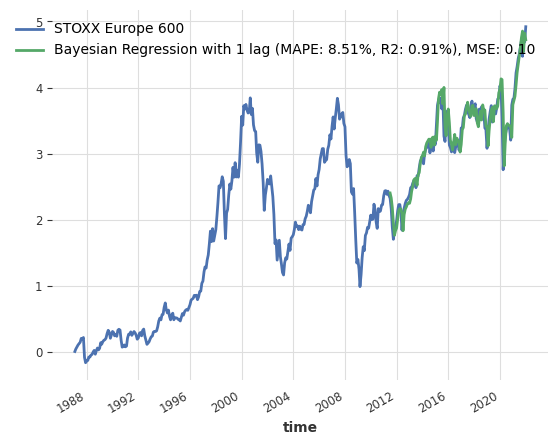

In [25]:
# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
hf1_bayesian['STOXX Europe 600'].plot(label='Bayesian Regression with 1 lag (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf1_bayesian, cum_returns), r2_score(hf1_bayesian, cum_returns), mse(hf1_bayesian, cum_returns)))

In [26]:
bayesian_forecast_1 = bayesian_forecast_1.pd_dataframe()

In [27]:
# perform mean-variance optimization with the ridge regression forecast
mu_bayesian_1 = expected_returns.mean_historical_return(bayesian_forecast_1)
S_bayesian_1 = risk_models.sample_cov(bayesian_forecast_1)

In [28]:
# optimize for maximal Sharpe ratio
ef_bayesian_1 = EfficientFrontier(mu_bayesian_1, S_bayesian_1)
ef_bayesian_1.add_constraint(lambda w: w[0] == 0)

weights_bayesian_1 = ef_bayesian_1.max_sharpe()

In [29]:
# get the cleaned weights
cleaned_weights_br_1 = ef_bayesian_1.clean_weights()

In [30]:
# print the cleaned weights
print(cleaned_weights_br_1)

OrderedDict([('STOXX Europe 600', 0.0), ('STOXX Europe Banks', 0.0), ('STOXX Europe Financials', 0.0), ('STOXX Europe Auto & Parts', 0.0), ('STOXX Europe Insurance', 0.0), ('STOXX Europe Technology', 0.00174), ('STOXX Europe Utilities', 0.0), ('STOXX Europe Chemicals', 0.14158), ('STOXX Europe Basic Resource', 0.0), ('STOXX Europe Con & Mat', 0.0), ('STOXX Europe Health Care', 0.85668), ('STOXX Europe Inds Gds & Svs', 0.0), ('STOXX Europe Media', 0.0), ('STOXX Europe Telecoms', 0.0)])


In [31]:
# calculate the return and volatility of the portfolio
br_returns_1 = (cum_returns_portfolio * cleaned_weights_br_1).sum(axis=1)

portfolio_returns['Bayesian Regression'] = br_returns_1

In [32]:
# show the last value of the portfolio
print('The last value of the Bayesian Regression portfolio is: ' + str(round(portfolio_returns.iloc[-1,2], 2)) + '%')

The last value of the Bayesian Regression portfolio is: 22.55%


### Linear Regression

In [33]:
# the only hyperparameter for the linear regression model is the number of lags
#hyperparameter_linear = {
#    "lags": list(range(1, 336))
#}

In [34]:
# the gridsearch function returns the best model with regard to the metric, which does not necessarily have to be the best model in terms of performance

#tuning_linear = LinearRegressionModel.gridsearch(
#    parameters= hyperparameter_linear,
#    series= train, # The target series used as input and target for training.
#    val_series= test,
#    start= 0.0, # represents the starting point in the time index of series from which predictions will be made to evaluate the model
#    #metric= , # function that takes actual and prediction, and returns a float error value
#    n_jobs= -1, # setting the parameter to -1 means using all the available cores
#    verbose= True # whether to print progress
#)

In [35]:
#best_model, best_params = tuning_linear[0], tuning_linear[1]
#best_model.model_params

In [36]:
# I have tested the model with different lags, which have shown the best results for mape and mse
linear_model_1 = LinearRegressionModel(lags=1, output_chunk_length=1)
linear_model_1.fit(train)
linear_forecast_1 = linear_model_1.predict(len(test))

# linear regression model with 316 lags of STOXX Europe 600
linear_model_316 = LinearRegressionModel(lags=316, output_chunk_length=1)
linear_model_316.fit(train)
linear_forecast_316 = linear_model_316.predict(len(test))

# linear regression model with 317 lags of STOXX Europe 600
linear_model_317 = LinearRegressionModel(lags=317, output_chunk_length=1)
linear_model_317.fit(train)
linear_forecast_317 = linear_model_317.predict(len(test))

# linear regression model with 335 lags of STOXX Europe 600
linear_model_335 = LinearRegressionModel(lags=335, output_chunk_length=1)
linear_model_335.fit(train) # ['STOXX Europe 600']
linear_forecast_335 = linear_model_335.predict(len(test))

%store linear_forecast_1
%store linear_forecast_316
%store linear_forecast_317
%store linear_forecast_335


Stored 'linear_forecast_1' (TimeSeries)
Stored 'linear_forecast_316' (TimeSeries)
Stored 'linear_forecast_317' (TimeSeries)
Stored 'linear_forecast_335' (TimeSeries)


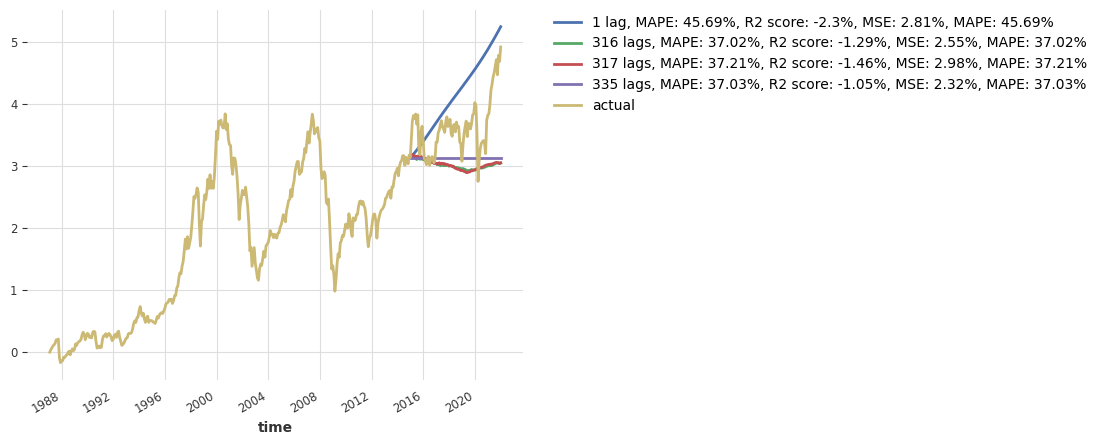

In [37]:
# plot linear forecast with 1, 316 and 335 lags and label with MAPE rounded to 2 decimals and R2 score rounded to 2 decimals and MSE rounded to 2 decimals
linear_forecast_1['STOXX Europe 600'].plot(label='1 lag, MAPE: ' + str(round(mape(test, linear_forecast_1), 2)) + '%, R2 score: ' + str(round(r2_score(test, linear_forecast_1), 2)) + '%, MSE: ' + str(round(mse(test, linear_forecast_1), 2)) + '%, MAPE: ' + str(round(mape(test, linear_forecast_1), 2)) + '%')
linear_forecast_316['STOXX Europe 600'].plot(label='316 lags, MAPE: ' + str(round(mape(test, linear_forecast_316), 2)) + '%, R2 score: ' + str(round(r2_score(test, linear_forecast_316), 2)) + '%, MSE: ' + str(round(mse(test, linear_forecast_316), 2)) + '%, MAPE: ' + str(round(mape(test, linear_forecast_316), 2)) + '%')
linear_forecast_317['STOXX Europe 600'].plot(label='317 lags, MAPE: ' + str(round(mape(test, linear_forecast_317), 2)) + '%, R2 score: ' + str(round(r2_score(test, linear_forecast_317), 2)) + '%, MSE: ' + str(round(mse(test, linear_forecast_317), 2)) + '%, MAPE: ' + str(round(mape(test, linear_forecast_317), 2)) + '%')
linear_forecast_335['STOXX Europe 600'].plot(label='335 lags, MAPE: ' + str(round(mape(test, linear_forecast_335), 2)) + '%, R2 score: ' + str(round(r2_score(test, linear_forecast_335), 2)) + '%, MSE: ' + str(round(mse(test, linear_forecast_335), 2)) + '%, MAPE: ' + str(round(mape(test, linear_forecast_335), 2)) + '%')

# rewrite to see only one line
cum_returns['STOXX Europe 600'].plot(label='actual')
# show the legend outside the plot 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [38]:
# we would assume that one of the model with the most lags would perform best, but this is not the case
# backtesting shows the following results

# first linear regression model with 1 lag
hf1_linear_regression = linear_model_1.historical_forecasts(
    series= cum_returns,    # the target time series used to successively train and compute the historical forecasts.
    start= 0.6,             # first point in time at which a prediction is computed for a future time
    forecast_horizon= 1,    # the forecast horizon for the predictions
    verbose= True
)

# second linear regression model with 316 lags
#hf2_linear_regression = linear_model_316.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

# third linear regression model with 317 lags
#hf3_linear_regression = linear_model_317.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

# fourth linear regression model with 335 lags
#hf4_linear_regression = linear_model_335.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

  0%|          | 0/169 [00:00<?, ?it/s]

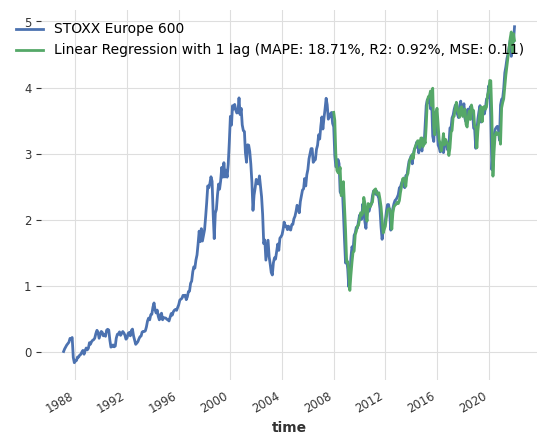

In [39]:
# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
hf1_linear_regression['STOXX Europe 600'].plot(label='Linear Regression with 1 lag (MAPE: {:.2f}%, R2: {:.2f}%, MSE: {:.2f})'.format(mape(hf1_linear_regression, cum_returns), r2_score(hf1_linear_regression, cum_returns), mse(hf1_linear_regression, cum_returns)))
#hf2_linear_regression['STOXX Europe 600'].plot(label='Linear Regression with 316 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf2_linear_regression, cum_returns), r2_score(hf2_linear_regression, cum_returns), mse(hf2_linear_regression, cum_returns)))
#hf3_linear_regression['STOXX Europe 600'].plot(label='Linear Regression with 317 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf3_linear_regression, cum_returns), r2_score(hf3_linear_regression, cum_returns), mse(hf3_linear_regression, cum_returns)))
#hf4_linear_regression['STOXX Europe 600'].plot(label='Linear Regression with 335 lags (MAPE: {:.2f}%, R2: {:.2f}%, MSE: {:.2f})'.format(mape(hf4_linear_regression, cum_returns), r2_score(hf4_linear_regression, cum_returns), mse(hf4_linear_regression, cum_returns)))

This shows that the model with 1 lags would have performed best, since it has the highest R2 and the lowest MSE. We will also check this when we build our portfolios using the different lag settings or forecasts, respectively.

#### Portfolio

In [40]:
# change the type of the linear_forecast to a pandas dataframe
linear_forecast_1 = linear_forecast_1.pd_dataframe()
linear_forecast_316 = linear_forecast_316.pd_dataframe()

In [41]:
# use the pyportfolioopt library to compute the optimal portfolio 

# perform mean-variance optimization with the linear regression forecast
mu_linear_regression_1 = expected_returns.mean_historical_return(linear_forecast_1)
S_linear_regression_1 = risk_models.sample_cov(linear_forecast_1)

mu_linear_regression_316 = expected_returns.mean_historical_return(linear_forecast_316)
S_linear_regression_316 = risk_models.sample_cov(linear_forecast_316)

In [42]:
# optimize for maximal sharpe ratio
# sharpe ratio is about to find the maximum return for a given risk

ef_linear_regression_1 = EfficientFrontier(mu_linear_regression_1, S_linear_regression_1)
ef_linear_regression_1.add_constraint(lambda w: w[0] == 0)
weights_lr_1 = ef_linear_regression_1.max_sharpe()

ef_linear_regression_316 = EfficientFrontier(mu_linear_regression_316, S_linear_regression_316)
ef_linear_regression_316.add_constraint(lambda w: w[0] == 0)
weights_lr_316 = ef_linear_regression_316.max_sharpe()

In [43]:
# print the weights in a table and round them to 4 decimals
print('Weights for Linear regression with 1 lag: ' + str(np.round(pd.Series(weights_lr_1), 3)))

Weights for Linear regression with 1 lag: STOXX Europe 600               0.000
STOXX Europe Banks             0.032
STOXX Europe Financials        0.000
STOXX Europe Auto & Parts      0.182
STOXX Europe Insurance        -0.000
STOXX Europe Technology        0.030
STOXX Europe Utilities         0.000
STOXX Europe Chemicals        -0.000
STOXX Europe Basic Resource    0.000
STOXX Europe Con & Mat         0.112
STOXX Europe Health Care       0.645
STOXX Europe Inds Gds & Svs   -0.000
STOXX Europe Media             0.000
STOXX Europe Telecoms          0.000
dtype: float64


In [44]:
# show the weights of the optimal portfolio cleaned
cleaned_weights_lr_1 = ef_linear_regression_1.clean_weights()
# print 
print('The weights of the optimal portfolio with 1 lag are: ' + str(cleaned_weights_lr_1))


The weights of the optimal portfolio with 1 lag are: OrderedDict([('STOXX Europe 600', 0.0), ('STOXX Europe Banks', 0.03175), ('STOXX Europe Financials', 0.0), ('STOXX Europe Auto & Parts', 0.182), ('STOXX Europe Insurance', 0.0), ('STOXX Europe Technology', 0.02975), ('STOXX Europe Utilities', 0.0), ('STOXX Europe Chemicals', 0.0), ('STOXX Europe Basic Resource', 0.0), ('STOXX Europe Con & Mat', 0.11165), ('STOXX Europe Health Care', 0.64485), ('STOXX Europe Inds Gds & Svs', 0.0), ('STOXX Europe Media', 0.0), ('STOXX Europe Telecoms', 0.0)])


In [147]:
# print the weights in a table and round them to 3 decimals and add their sum
print('Weights for linear regression with 1 lag: ' + str(np.round(pd.Series(weights_lr_1), 3)))
#print('Weights for linear regression with 316 lags: ' + str(np.round(pd.Series(weights_lr_316), 3)))

Weights for linear regression with 1 lag: STOXX Europe 600               0.000
STOXX Europe Banks             0.032
STOXX Europe Financials        0.000
STOXX Europe Auto & Parts      0.182
STOXX Europe Insurance        -0.000
STOXX Europe Technology        0.030
STOXX Europe Utilities         0.000
STOXX Europe Chemicals        -0.000
STOXX Europe Basic Resource    0.000
STOXX Europe Con & Mat         0.112
STOXX Europe Health Care       0.645
STOXX Europe Inds Gds & Svs   -0.000
STOXX Europe Media             0.000
STOXX Europe Telecoms          0.000
dtype: float64


In [46]:
lr_returns_1 = (cum_returns_portfolio * cleaned_weights_lr_1).sum(axis=1)
lr_returns_316 = (cum_returns_portfolio * weights_lr_316).sum(axis=1)

# Add portfolio_returns as a new column in cum_returns
portfolio_returns['linear_regression_1'] = lr_returns_1
portfolio_returns['linear_regression_316'] = lr_returns_316

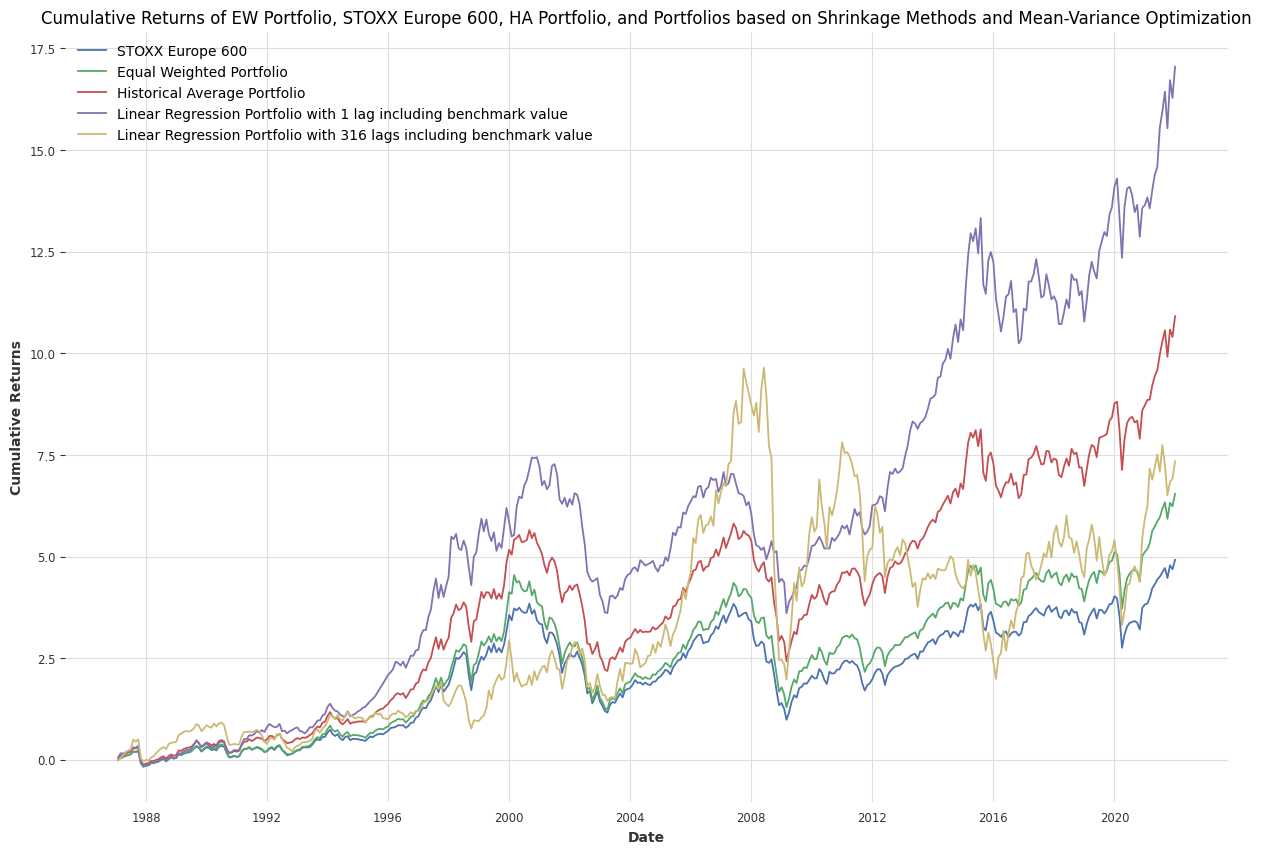

In [47]:
# plot the cumulative returns of the benchmarks and the portfolio constructed with the linear regression forecast
plt.figure(figsize=(15,10))
plt.plot(cum_returns_portfolio['STOXX Europe 600'], label='STOXX Europe 600')
plt.plot(portfolio_returns['equal_weighted'], label='Equal Weighted Portfolio')
plt.plot(portfolio_returns['historical_average'], label='Historical Average Portfolio')
plt.plot(portfolio_returns['linear_regression_1'], label='Linear Regression Portfolio with 1 lag including benchmark value')
plt.plot(portfolio_returns['linear_regression_316'], label='Linear Regression Portfolio with 316 lags including benchmark value')
plt.legend(loc='upper left')
plt.title('Cumulative Returns of EW Portfolio, STOXX Europe 600, HA Portfolio, and Portfolios based on Shrinkage Methods and Mean-Variance Optimization')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show();

In [48]:
#show the last value of each portfolio in percent and round two 2 decimals
print('Last value of the STOXX Europe 600: ' + str(round(cum_returns_portfolio['STOXX Europe 600'].iloc[-1], 2)) + '%')
print('Last value of the equal weighted portfolio: ' + str(round(portfolio_returns['equal_weighted'].iloc[-1], 2)) + '%')
print('Last value of the historical average portfolio: ' + str(round(portfolio_returns['historical_average'].iloc[-1], 2)) + '%')
print('Last value of the linear regression portfolio with 1 lag: ' + str(round(portfolio_returns['linear_regression_1'].iloc[-1], 2)) + '%')
print('Last value of the linear regression portfolio with 316 lags: ' + str(round(portfolio_returns['linear_regression_316'].iloc[-1], 2)) + '%')

Last value of the STOXX Europe 600: 4.92%
Last value of the equal weighted portfolio: 6.54%
Last value of the historical average portfolio: 10.91%
Last value of the linear regression portfolio with 1 lag: 17.05%
Last value of the linear regression portfolio with 316 lags: 7.35%


In [49]:
#compute the volatility of each portfolio
print('Volatility of the STOXX Europe 600: ' + str(round(cum_returns_portfolio['STOXX Europe 600'].std(), 2)) + '%')
print('Volatility of the equal weighted portfolio: ' + str(round(portfolio_returns['equal_weighted'].std(), 2)) + '%')
print('Volatility of the historical average portfolio: ' + str(round(portfolio_returns['historical_average'].std(), 2)) + '%')
print('Volatility of the linear regression portfolio with 1 lag: ' + str(round(portfolio_returns['linear_regression_1'].std(), 2)) + '%')
print('Volatility of the linear regression portfolio with 316 lags: ' + str(round(portfolio_returns['linear_regression_316'].std(), 2)) + '%')

Volatility of the STOXX Europe 600: 1.31%
Volatility of the equal weighted portfolio: 1.63%
Volatility of the historical average portfolio: 2.67%
Volatility of the linear regression portfolio with 1 lag: 4.25%
Volatility of the linear regression portfolio with 316 lags: 2.36%


In [50]:
# show shape of portfolio_returns
print(portfolio_returns.iloc[-1].shape)
# show shape of cum_returns_portfolio
print(cum_returns_portfolio.shape)
# show shape of cum_returns_portfolio.std()
print(portfolio_returns.std().shape)

(5,)
(420, 14)
(5,)


This shows once more, that the forecasts with 1 lag perform best.

#### Plots Portfolio Analysis

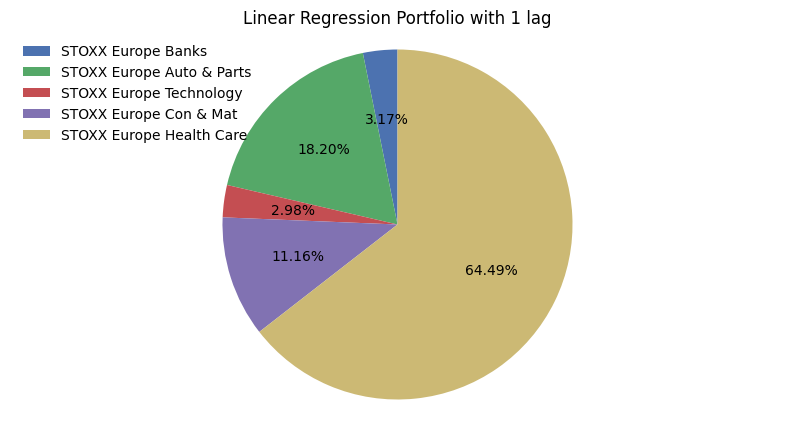

In [51]:
generate_pie_chart(weights_lr_1, 'Linear Regression Portfolio with 1 lag')

Weights:
                 STOXX Europe Banks  STOXX Europe Auto & Parts  STOXX Europe Technology  STOXX Europe Con & Mat  STOXX Europe Health Care  STOXX Europe Media     Sum
Max Sharpe                   3.17%                     18.20%                    2.97%                  11.16%                    64.48%               0.00% 100.00%
Min Volatility               6.82%                      9.27%                    0.00%                  11.16%                    55.91%              16.84% 100.00%

Performance:
                 Return  Volatility
Max Sharpe      17.05%       4.25%
Min Volatility  15.25%       3.78%


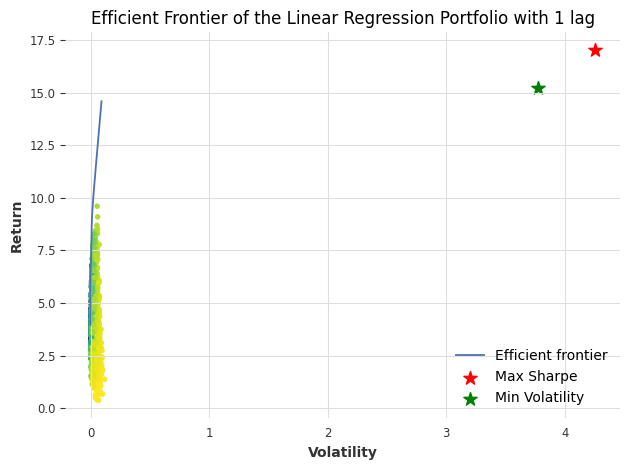

In [52]:
plot_efficient_frontier(mu_linear_regression_1, S_linear_regression_1, cum_returns_portfolio, 'Efficient Frontier of the Linear Regression Portfolio with 1 lag')

In [145]:
weights_lr_1

OrderedDict([('STOXX Europe 600', 5e-16),
             ('STOXX Europe Banks', 0.0317497087585925),
             ('STOXX Europe Financials', 1.8e-15),
             ('STOXX Europe Auto & Parts', 0.1819952340709804),
             ('STOXX Europe Insurance', -8.1e-15),
             ('STOXX Europe Technology', 0.0297535688470437),
             ('STOXX Europe Utilities', 2.8e-15),
             ('STOXX Europe Chemicals', -5e-16),
             ('STOXX Europe Basic Resource', 1e-16),
             ('STOXX Europe Con & Mat', 0.1116468763084599),
             ('STOXX Europe Health Care', 0.6448546120149075),
             ('STOXX Europe Inds Gds & Svs', -3e-16),
             ('STOXX Europe Media', 1.6e-15),
             ('STOXX Europe Telecoms', 1.77e-14)])

### Ridge Regression

In [53]:
#hyperparameter_ridge = {
#    "lags": list(range(1,336,2)),
#    'model': [
#        sklearn.linear_model.Ridge(alpha=a) for a in np.arange(0, 1.1, 0.1)
#    ]
#}

In [54]:
#ridge_regression_tune = RegressionModel(
#    lags= hyperparameter_ridge['lags'][0],
#    model=sklearn.linear_model.Ridge(0)
#)

In [55]:
#tuning_ridge = ridge_regression_tune.gridsearch(
#    parameters= hyperparameter_ridge,
#    series= train,
#    val_series= test,
#    start= 0.1,
#    #metric= mse,
#    n_jobs= -1,
#    verbose= True
#)

In [56]:
#best_model, best_params = tuning_ridge[0], tuning_ridge[1]
#best_model.model_params

In [57]:
# I have tested the model with different lags, which have shown the best results for mape and mse
# ridge regression model with 1 lag of STOXX Europe 600
ridge_model_1 = RegressionModel(lags=1, model=sklearn.linear_model.Ridge(alpha=1))
ridge_model_1.fit(train)
ridge_forecast_1 = ridge_model_1.predict(len(test))

# ridge regression model with 316 lags of STOXX Europe 600
ridge_model_316 =RegressionModel(lags=316, model=sklearn.linear_model.Ridge(alpha=1))
ridge_model_316.fit(train)
ridge_forecast_316 = ridge_model_316.predict(len(test))

# ridge regression model with 317 lags of STOXX Europe 600
ridge_model_317 = RegressionModel(lags=317, model=sklearn.linear_model.Ridge(alpha=1))
ridge_model_317.fit(train)
ridge_forecast_317 = ridge_model_317.predict(len(test))

# ridge regression model with 335 lags of STOXX Europe 600
ridge_model_335 = RegressionModel(lags=335, model=sklearn.linear_model.Ridge(alpha=1))
ridge_model_335.fit(train)
ridge_forecast_335 = ridge_model_335.predict(len(test))

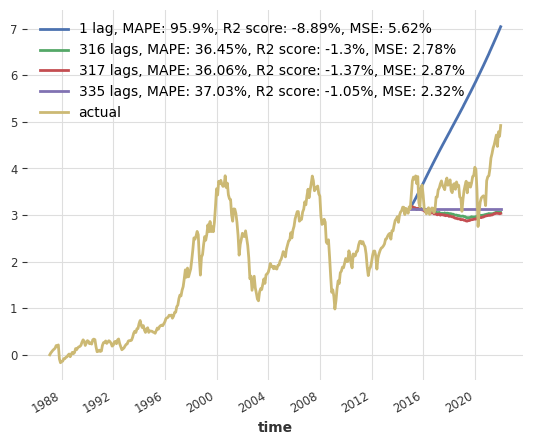

In [58]:
# plot the ridge forecast with 1, 316, 317 and 335 lags and label with MAPE rounded to 2 decimals and R2 score rounded to 2 decimals and MSE rounded to 2 decimals
ridge_forecast_1['STOXX Europe 600'].plot(label='1 lag, MAPE: ' + str(round(mape(test, ridge_forecast_1), 2)) + '%, R2 score: ' + str(round(r2_score(test, ridge_forecast_1), 2)) + '%, MSE: ' + str(round(mse(test, ridge_forecast_1), 2)) + '%')
ridge_forecast_316['STOXX Europe 600'].plot(label='316 lags, MAPE: ' + str(round(mape(test, ridge_forecast_316), 2)) + '%, R2 score: ' + str(round(r2_score(test, ridge_forecast_316), 2)) + '%, MSE: ' + str(round(mse(test, ridge_forecast_316), 2)) + '%')
ridge_forecast_317['STOXX Europe 600'].plot(label='317 lags, MAPE: ' + str(round(mape(test, ridge_forecast_317), 2)) + '%, R2 score: ' + str(round(r2_score(test, ridge_forecast_317), 2)) + '%, MSE: ' + str(round(mse(test, ridge_forecast_317), 2)) + '%')
ridge_forecast_335['STOXX Europe 600'].plot(label='335 lags, MAPE: ' + str(round(mape(test, ridge_forecast_335), 2)) + '%, R2 score: ' + str(round(r2_score(test, ridge_forecast_335), 2)) + '%, MSE: ' + str(round(mse(test, ridge_forecast_335), 2)) + '%')

# rewrite to see only one line
cum_returns['STOXX Europe 600'].plot(label='actual')

In [59]:
# first ridge regression model with 1 lag
hf1_ridge_regression = ridge_model_1.historical_forecasts(
    series= cum_returns,    # the target time series used to successively train and compute the historical forecasts.
    start= 0.7,             # first point in time at which a prediction is computed for a future time
    forecast_horizon= 1,    # the forecast horizon for the predictions
    verbose= True
)

# second ridge regression model with 316 lags
hf2_ridge_regression = ridge_model_316.historical_forecasts(
    series= cum_returns,    # the target time series used to successively train and compute the historical forecasts.
    start= 0.6,             # first point in time at which a prediction is computed for a future time
    forecast_horizon= 1,    # the forecast horizon for the predictions
    verbose= True
)

# third ridge regression model with 317 lags
#hf3_ridge_regression = ridge_model_317.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

# fourth ridge regression model with 335 lags
#hf4_ridge_regression = ridge_model_335.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

  0%|          | 0/127 [00:00<?, ?it/s]

`start` value `0.6` corresponding to timestamp `2008-01-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2013-08-01 00:00:00. To hide these warnings, set `show_warnings=False`.


  0%|          | 0/102 [00:00<?, ?it/s]

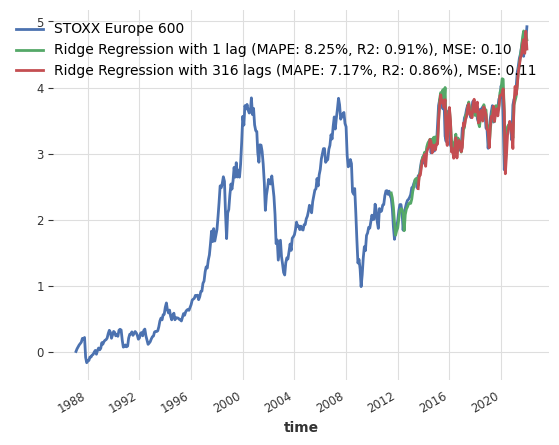

In [60]:
# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
hf1_ridge_regression['STOXX Europe 600'].plot(label='Ridge Regression with 1 lag (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf1_ridge_regression, cum_returns), r2_score(hf1_ridge_regression, cum_returns), mse(hf1_ridge_regression, cum_returns)))
hf2_ridge_regression['STOXX Europe 600'].plot(label='Ridge Regression with 316 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf2_ridge_regression, cum_returns), r2_score(hf2_ridge_regression, cum_returns), mse(hf2_ridge_regression, cum_returns)))
#hf3_ridge_regression['STOXX Europe 600'].plot(label='Ridge Regression with 317 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf3_ridge_regression, cum_returns), r2_score(hf3_ridge_regression, cum_returns), mse(hf3_ridge_regression, cum_returns)))
#hf4_ridge_regression['STOXX Europe 600'].plot(label='Ridge Regression with 335 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf4_ridge_regression, cum_returns), r2_score(hf4_ridge_regression, cum_returns), mse(hf4_ridge_regression, cum_returns)))

#### Portfolio

In [61]:
ridge_forecast_1 = ridge_forecast_1.pd_dataframe()
ridge_forecast_316 = ridge_forecast_316.pd_dataframe()

In [62]:
# perform mean-variance optimization with the ridge regression forecast
mu_ridge_regression_1 = expected_returns.mean_historical_return(ridge_forecast_1)
S_ridge_regression_1 = risk_models.sample_cov(ridge_forecast_1)

mu_ridge_regression_316 = expected_returns.mean_historical_return(ridge_forecast_316)
S_ridge_regression_316 = risk_models.sample_cov(ridge_forecast_316)

In [63]:
# optimize for maximal Sharpe ratio
ef_ridge_regression_1 = EfficientFrontier(mu_ridge_regression_1, S_ridge_regression_1)
ef_ridge_regression_1.add_constraint(lambda w: w[0] == 0)
ef_ridge_regression_316 = EfficientFrontier(mu_ridge_regression_316, S_ridge_regression_316)
ef_ridge_regression_316.add_constraint(lambda w: w[0] == 0)

weights_rr_1 = ef_ridge_regression_1.max_sharpe()
weights_rr_316 = ef_ridge_regression_316.max_sharpe()

In [64]:
# get the cleaned weights
cleaned_weights_rr_1 = ef_ridge_regression_1.clean_weights()
cleaned_weights_rr_316 = ef_ridge_regression_316.clean_weights()

In [65]:
# print the weights in a table and round them to 2 decimal places
print('Weights for ridge regression with 1 lag: ' + str(np.round(pd.Series(weights_rr_1), 3)))
print('Weights for ridge regression with 316 lags: ' + str(np.round(pd.Series(weights_rr_316), 3)))

Weights for ridge regression with 1 lag: STOXX Europe 600               0.0
STOXX Europe Banks             0.0
STOXX Europe Financials        0.0
STOXX Europe Auto & Parts      0.0
STOXX Europe Insurance         0.0
STOXX Europe Technology        0.0
STOXX Europe Utilities         0.0
STOXX Europe Chemicals         0.0
STOXX Europe Basic Resource    0.0
STOXX Europe Con & Mat         0.0
STOXX Europe Health Care       1.0
STOXX Europe Inds Gds & Svs    0.0
STOXX Europe Media             0.0
STOXX Europe Telecoms          0.0
dtype: float64
Weights for ridge regression with 316 lags: STOXX Europe 600              -0.0
STOXX Europe Banks            -0.0
STOXX Europe Financials        0.0
STOXX Europe Auto & Parts      0.0
STOXX Europe Insurance         0.0
STOXX Europe Technology        0.0
STOXX Europe Utilities         0.0
STOXX Europe Chemicals        -0.0
STOXX Europe Basic Resource    1.0
STOXX Europe Con & Mat         0.0
STOXX Europe Health Care      -0.0
STOXX Europe Inds Gds & S

In [66]:
# calculate the returns of the ridge regression portfolio
rr_returns_1 = (cum_returns_portfolio * weights_rr_1).sum(axis=1)
rr_returns_316 = (cum_returns_portfolio * weights_rr_316).sum(axis=1)

portfolio_returns['ridge_regression_1'] = rr_returns_1
portfolio_returns['ridge_regression_316'] = rr_returns_316

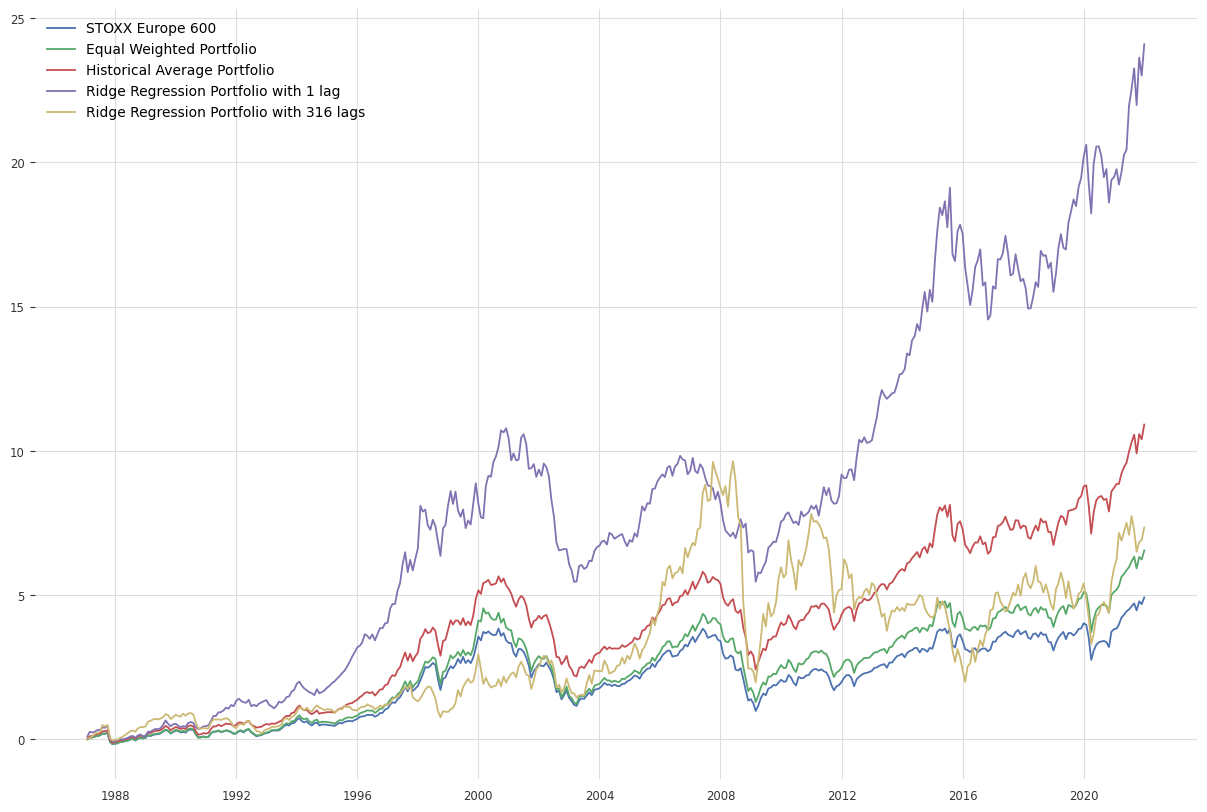

In [67]:
# plot the cumulative returns of the benchmark and the ridge regression portfolio
plt.figure(figsize=(15,10))
plt.plot(cum_returns_portfolio['STOXX Europe 600'], label='STOXX Europe 600')
plt.plot(portfolio_returns['equal_weighted'], label='Equal Weighted Portfolio')
plt.plot(portfolio_returns['historical_average'], label='Historical Average Portfolio')
plt.plot(portfolio_returns['ridge_regression_1'], label='Ridge Regression Portfolio with 1 lag')
plt.plot(portfolio_returns['ridge_regression_316'], label='Ridge Regression Portfolio with 316 lags')
plt.legend()
plt.show();

In [68]:
# show the last value of each portfolio and round it to 2 decimal places
print('Last value of the STOXX Europe 600: ' + str(np.round(cum_returns_portfolio['STOXX Europe 600'].iloc[-1], 2)) + '%')
print('Last value of the equal weighted portfolio: ' + str(np.round(portfolio_returns['equal_weighted'].iloc[-1], 2)) + '%')
print('Last value of the historical average portfolio: ' + str(np.round(portfolio_returns['historical_average'].iloc[-1], 2)) + '%')
print('Last value of the ridge regression portfolio with 1 lag: ' + str(np.round(portfolio_returns['ridge_regression_1'].iloc[-1], 12)) + '%')
print('Last value of the ridge regression portfolio with 316 lags: ' + str(np.round(portfolio_returns['ridge_regression_316'].iloc[-1], 5)) + '%')
# also for the linear regression portfolio
print('Last value of the linear regression portfolio: ' + str(np.round(portfolio_returns['linear_regression_1'].iloc[-1], 12)) + '%')
print('Last value of the linear regression portfolio: ' + str(np.round(portfolio_returns['linear_regression_316'].iloc[-1], 5)) + '%')


Last value of the STOXX Europe 600: 4.92%
Last value of the equal weighted portfolio: 6.54%
Last value of the historical average portfolio: 10.91%
Last value of the ridge regression portfolio with 1 lag: 24.096923076923%
Last value of the ridge regression portfolio with 316 lags: 7.34664%
Last value of the linear regression portfolio: 17.049795703909%
Last value of the linear regression portfolio: 7.34673%


#### Plots Portfolio Analysis  

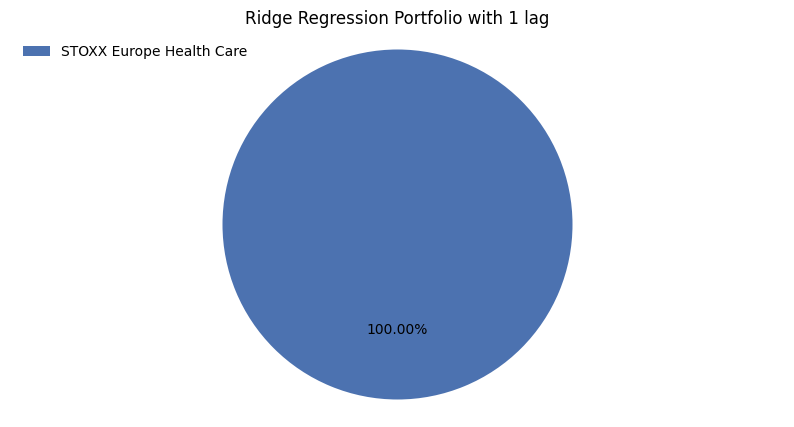

In [69]:
generate_pie_chart(weights_rr_1, 'Ridge Regression Portfolio with 1 lag')

Weights:
                 STOXX Europe Health Care     Sum
Max Sharpe                       100.00% 100.00%
Min Volatility                   100.00% 100.00%

Performance:
                 Return  Volatility
Max Sharpe      24.10%       6.03%
Min Volatility  24.10%       6.03%


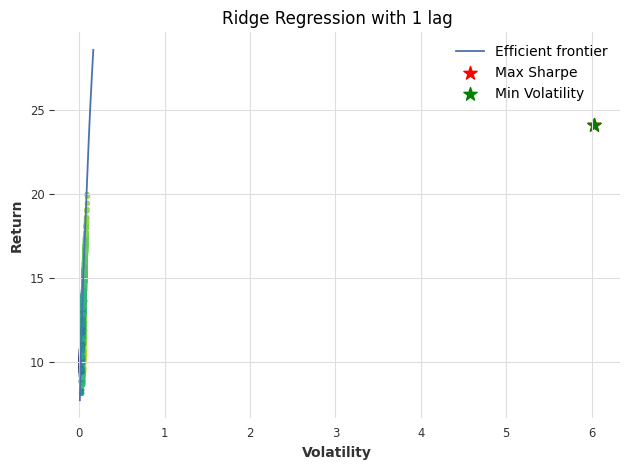

In [70]:
# use the function to plot efficient frontiers for the ridge regression portfolios and the maximum Sharpe ratio portfolio
plot_efficient_frontier(mu_ridge_regression_1, S_ridge_regression_1, cum_returns_portfolio, 'Ridge Regression with 1 lag')

### Lasso Regression

In [71]:
#hyperparameter_lasso = {
#    "lags": list(range(1,2)),
#    'model': [
#        sklearn.linear_model.Lasso(alpha=a) for a in np.arange(0, 1.1, 0.01)
#    ]
#}

In [72]:
#lasso_regression_tune = RegressionModel(
#    lags= hyperparameter_lasso['lags'][0],
#    model=sklearn.linear_model.Lasso(0)
#)

In [73]:
"""tuning_lasso = lasso_regression_tune.gridsearch(
    parameters= hyperparameter_lasso,
    series= train,
    val_series= test,
    start= 0.1,
    #metric= mape,
    n_jobs= -1,
    verbose= True
)"""

'tuning_lasso = lasso_regression_tune.gridsearch(\n    parameters= hyperparameter_lasso,\n    series= train,\n    val_series= test,\n    start= 0.1,\n    #metric= mape,\n    n_jobs= -1,\n    verbose= True\n)'

In [74]:
"""best_model, best_params = tuning_lasso[0], tuning_lasso[1]
best_model.model_params"""

'best_model, best_params = tuning_lasso[0], tuning_lasso[1]\nbest_model.model_params'

In [75]:
# I have tested the model with different lags, which have shown the best results for mape and mse
# lasso regression model with 1 lag of STOXX Europe 600
lasso_model_1 = RegressionModel(lags=1, model=sklearn.linear_model.Lasso(alpha=0))
lasso_model_1.fit(train)
lasso_forecast_1 = lasso_model_1.predict(len(test))

# lasso regression model with 316 lags of STOXX Europe 600
lasso_model_316 = RegressionModel(lags=316, model=sklearn.linear_model.Lasso(alpha=0))
lasso_model_316.fit(train)
lasso_forecast_316 = lasso_model_316.predict(len(test))

# lasso regression model with 317 lags of STOXX Europe 600
lasso_model_317 = RegressionModel(lags=317, model=sklearn.linear_model.Lasso(alpha=0))
lasso_model_317.fit(train)
lasso_forecast_317 = lasso_model_317.predict(len(test))

# lasso regression model with 335 lags of STOXX Europe 600
lasso_model_335 = RegressionModel(lags=335, model=sklearn.linear_model.Lasso(alpha=0))
lasso_model_335.fit(train)
lasso_forecast_335 = lasso_model_335.predict(len(test))

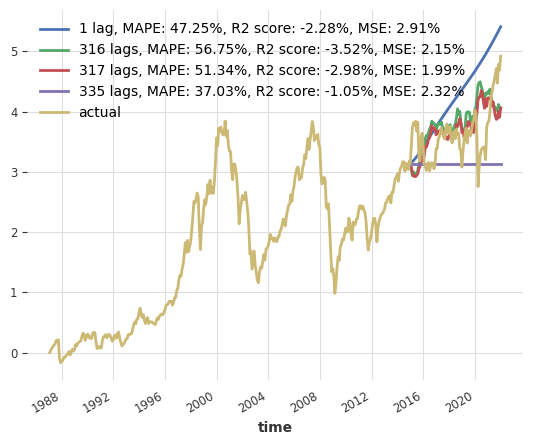

In [76]:
# plot the lasso forecast with 1, 316, 317 and 335 lags and label with MAPE rounded to 2 decimals and R2 score rounded to 2 decimals and MSE rounded to 2 decimals
lasso_forecast_1['STOXX Europe 600'].plot(label='1 lag, MAPE: ' + str(round(mape(test, lasso_forecast_1), 2)) + '%, R2 score: ' + str(round(r2_score(test, lasso_forecast_1), 2)) + '%, MSE: ' + str(round(mse(test, lasso_forecast_1), 2)) + '%')
lasso_forecast_316['STOXX Europe 600'].plot(label='316 lags, MAPE: ' + str(round(mape(test, lasso_forecast_316), 2)) + '%, R2 score: ' + str(round(r2_score(test, lasso_forecast_316), 2)) + '%, MSE: ' + str(round(mse(test, lasso_forecast_316), 2)) + '%')
lasso_forecast_317['STOXX Europe 600'].plot(label='317 lags, MAPE: ' + str(round(mape(test, lasso_forecast_317), 2)) + '%, R2 score: ' + str(round(r2_score(test, lasso_forecast_317), 2)) + '%, MSE: ' + str(round(mse(test, lasso_forecast_317), 2)) + '%')
lasso_forecast_335['STOXX Europe 600'].plot(label='335 lags, MAPE: ' + str(round(mape(test, lasso_forecast_335), 2)) + '%, R2 score: ' + str(round(r2_score(test, lasso_forecast_335), 2)) + '%, MSE: ' + str(round(mse(test, lasso_forecast_335), 2)) + '%')

# rewrite to see only one line
cum_returns['STOXX Europe 600'].plot(label='actual')

In [77]:
# first lasso regression model with 1 lag
hf1_lasso_regression = lasso_model_1.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

# second lasso regression model with 316 lags
hf2_lasso_regression = lasso_model_316.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

# third lasso regression model with 317 lags
#hf3_lasso_regression = lasso_model_317.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

# fourth lasso regression model with 335 lags
#hf4_lasso_regression = lasso_model_335.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

  0%|          | 0/169 [00:00<?, ?it/s]

`start` value `0.6` corresponding to timestamp `2008-01-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2013-08-01 00:00:00. To hide these warnings, set `show_warnings=False`.


  0%|          | 0/102 [00:00<?, ?it/s]

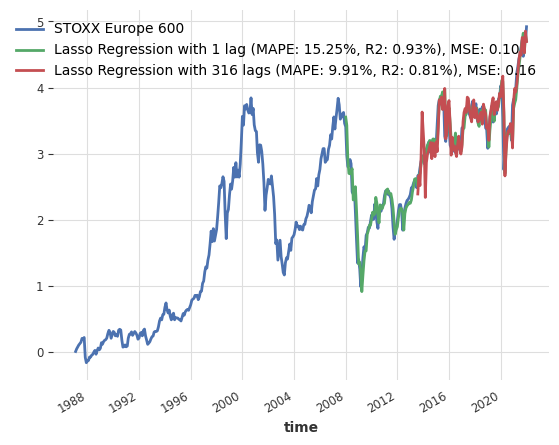

In [78]:
# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
hf1_lasso_regression['STOXX Europe 600'].plot(label='Lasso Regression with 1 lag (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf1_lasso_regression, cum_returns), r2_score(hf1_lasso_regression, cum_returns), mse(hf1_ridge_regression, cum_returns)))
hf2_lasso_regression['STOXX Europe 600'].plot(label='Lasso Regression with 316 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf2_lasso_regression, cum_returns), r2_score(hf2_lasso_regression, cum_returns), mse(hf2_lasso_regression, cum_returns)))
#hf3_lasso_regression['STOXX Europe 600'].plot(label='Lasso Regression with 317 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf3_lasso_regression, cum_returns), r2_score(hf3_lasso_regression, cum_returns), mse(hf3_lasso_regression, cum_returns)))
#hf4_lasso_regression['STOXX Europe 600'].plot(label='Lasso Regression with 335 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf4_lasso_regression, cum_returns), r2_score(hf4_lasso_regression, cum_returns), mse(hf4_lasso_regression, cum_returns)))

#### Portfolio

In [79]:
lasso_forecast_1 = lasso_forecast_1.pd_dataframe()
lasso_forecast_316 = lasso_forecast_316.pd_dataframe()

In [80]:
# perform mean-variance optimization
mu_lasso_regression_1 = expected_returns.mean_historical_return(lasso_forecast_1)
S_lasso_regression_1 = risk_models.sample_cov(lasso_forecast_1)

mu_lasso_regression_316 = expected_returns.mean_historical_return(lasso_forecast_316)
S_lasso_regression_316 = risk_models.sample_cov(lasso_forecast_316)

In [81]:
# optimize for maximal Sharpe ratio
ef_lasso_regression_1 = EfficientFrontier(mu_lasso_regression_1, S_lasso_regression_1)
ef_lasso_regression_1.add_constraint(lambda w: w[0] == 0)
weights_lar_1 = ef_lasso_regression_1.max_sharpe()

ef_lasso_regression_316 = EfficientFrontier(mu_lasso_regression_316, S_lasso_regression_316)
ef_lasso_regression_316.add_constraint(lambda w: w[0] == 0)
weights_lar_316 = ef_lasso_regression_316.max_sharpe()

In [82]:
# print the weights in a table and round them to 4 decimals
print('Weights for lasso regression with 1 lag: ' + str(np.round(pd.Series(weights_lar_1), 3)))
print('Weights for lasso regression with 316 lags: ' + str(np.round(pd.Series(weights_lar_316), 3)))

Weights for lasso regression with 1 lag: STOXX Europe 600               0.000
STOXX Europe Banks             0.000
STOXX Europe Financials        0.000
STOXX Europe Auto & Parts      0.000
STOXX Europe Insurance         0.000
STOXX Europe Technology        0.023
STOXX Europe Utilities         0.000
STOXX Europe Chemicals         0.000
STOXX Europe Basic Resource    0.108
STOXX Europe Con & Mat         0.000
STOXX Europe Health Care       0.869
STOXX Europe Inds Gds & Svs    0.000
STOXX Europe Media             0.000
STOXX Europe Telecoms          0.000
dtype: float64
Weights for lasso regression with 316 lags: STOXX Europe 600               0.000
STOXX Europe Banks             0.000
STOXX Europe Financials        0.000
STOXX Europe Auto & Parts      0.111
STOXX Europe Insurance         0.886
STOXX Europe Technology        0.000
STOXX Europe Utilities         0.000
STOXX Europe Chemicals         0.000
STOXX Europe Basic Resource    0.000
STOXX Europe Con & Mat         0.000
STOXX Europe

In [83]:
# compute the returns of lasso regression portfolio
lar_returns_1 = (cum_returns_portfolio * weights_lar_1).sum(axis=1)
lar_returns_316 = (cum_returns_portfolio * weights_lar_316).sum(axis=1)

portfolio_returns['lasso_regression_1'] = lar_returns_1
portfolio_returns['lasso_regression_316'] = lar_returns_316

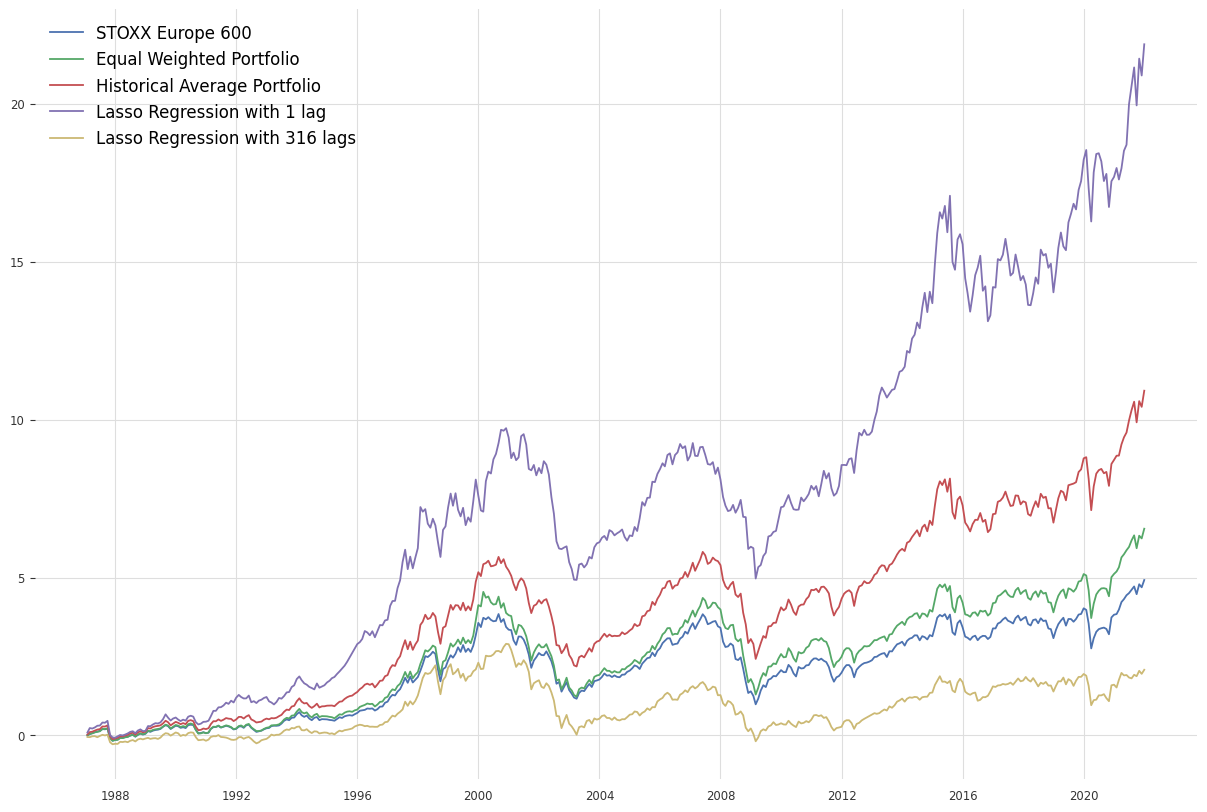

In [84]:
# plot the cumulative returns of the benchmark and the lasso regression portfolio
plt.figure(figsize=(15,10))
plt.plot(cum_returns_portfolio['STOXX Europe 600'], label='STOXX Europe 600')
plt.plot(portfolio_returns['equal_weighted'], label='Equal Weighted Portfolio')
plt.plot(portfolio_returns['historical_average'], label='Historical Average Portfolio')
plt.plot(portfolio_returns['lasso_regression_1'], label='Lasso Regression with 1 lag')
plt.plot(portfolio_returns['lasso_regression_316'], label='Lasso Regression with 316 lags')
plt.legend(loc='upper left', fontsize=12)
plt.show();

In [85]:
# show the last value of each portfolio and round it to 2 decimal places
print('Last value of the STOXX Europe 600: ' + str(np.round(cum_returns_portfolio['STOXX Europe 600'].iloc[-1], 2)) + '%')
print('Last value of the equal weighted portfolio: ' + str(np.round(portfolio_returns['equal_weighted'].iloc[-1], 2)) + '%')
print('Last value of the historical average portfolio: ' + str(np.round(portfolio_returns['historical_average'].iloc[-1], 2)) + '%')
print('Last value of the ridge regression portfolio with 1 lag: ' + str(np.round(portfolio_returns['ridge_regression_1'].iloc[-1], 12)) + '%')
print('Last value of the ridge regression portfolio with 316 lags: ' + str(np.round(portfolio_returns['ridge_regression_316'].iloc[-1], 5)) + '%')
# also for the linear regression portfolio
print('Last value of the linear regression portfolio: ' + str(np.round(portfolio_returns['linear_regression_1'].iloc[-1], 12)) + '%')
print('Last value of the linear regression portfolio: ' + str(np.round(portfolio_returns['linear_regression_316'].iloc[-1], 5)) + '%')
# also for lasso regression portfolio
print('Last value of the lasso regression portfolio with 1 lag: ' + str(np.round(portfolio_returns['lasso_regression_1'].iloc[-1], 2)) + '%')
print('Last value of the lasso regression portfolio with 316 lags: ' + str(np.round(portfolio_returns['lasso_regression_316'].iloc[-1], 2)) + '%')

Last value of the STOXX Europe 600: 4.92%
Last value of the equal weighted portfolio: 6.54%
Last value of the historical average portfolio: 10.91%
Last value of the ridge regression portfolio with 1 lag: 24.096923076923%
Last value of the ridge regression portfolio with 316 lags: 7.34664%
Last value of the linear regression portfolio: 17.049795703909%
Last value of the linear regression portfolio: 7.34673%
Last value of the lasso regression portfolio with 1 lag: 21.88%
Last value of the lasso regression portfolio with 316 lags: 2.08%


#### Plots Portfolio Analysis

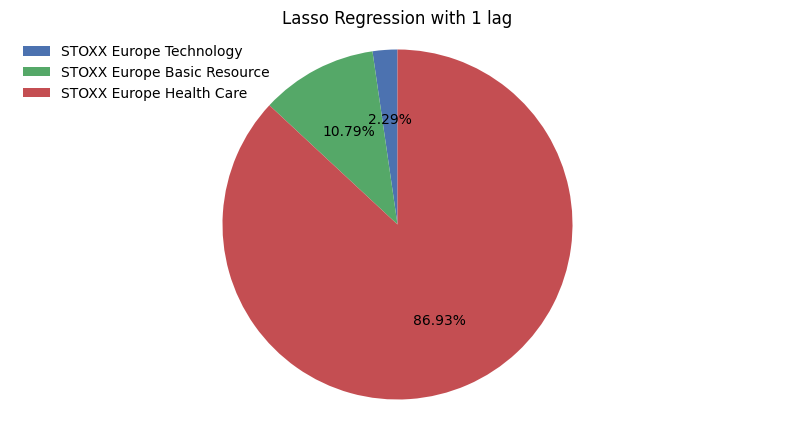

In [86]:
generate_pie_chart(weights_lar_1, 'Lasso Regression with 1 lag')


Weights:
                 STOXX Europe Technology  STOXX Europe Basic Resource  STOXX Europe Health Care     Sum
Max Sharpe                        2.29%                       10.79%                    86.93% 100.00%
Min Volatility                    2.20%                       10.48%                    87.32% 100.00%

Performance:
                 Return  Volatility
Max Sharpe      21.88%       5.44%
Min Volatility  21.95%       5.46%


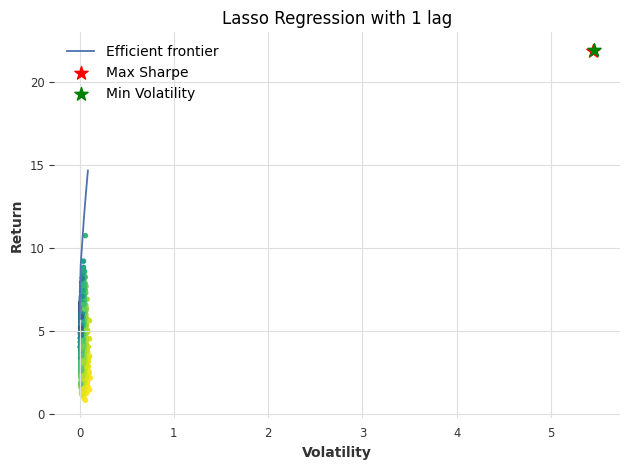

In [87]:
plot_efficient_frontier(mu_lasso_regression_1, S_lasso_regression_1, cum_returns_portfolio, 'Lasso Regression with 1 lag')

### Elastic Net

In [88]:
"""hyperparameter_elastic = {
    "lags": list(range(1,2)),
    'model': [
        sklearn.linear_model.ElasticNet(alpha=a) for a in np.arange(0, 1.1, 0.01)
    ]
}"""

'hyperparameter_elastic = {\n    "lags": list(range(1,2)),\n    \'model\': [\n        sklearn.linear_model.ElasticNet(alpha=a) for a in np.arange(0, 1.1, 0.01)\n    ]\n}'

In [89]:
"""elastic_net_tune = RegressionModel(
    lags= hyperparameter_elastic['lags'][0],
    model=sklearn.linear_model.ElasticNet(0)
)"""

"elastic_net_tune = RegressionModel(\n    lags= hyperparameter_elastic['lags'][0],\n    model=sklearn.linear_model.ElasticNet(0)\n)"

In [90]:
"""tuning_elastic_net = elastic_net_tune.gridsearch(
    parameters= hyperparameter_elastic,
    series= train,
    val_series= test,
    start= 0.1,
   # metric= mape,
    n_jobs= -1,
    verbose= True
)"""

'tuning_elastic_net = elastic_net_tune.gridsearch(\n    parameters= hyperparameter_elastic,\n    series= train,\n    val_series= test,\n    start= 0.1,\n   # metric= mape,\n    n_jobs= -1,\n    verbose= True\n)'

In [91]:
"""best_model, best_params = tuning_elastic_net[0], tuning_elastic_net[1]
# print the best model parameters
best_model.model_params"""

'best_model, best_params = tuning_elastic_net[0], tuning_elastic_net[1]\n# print the best model parameters\nbest_model.model_params'

In [92]:
# I have tested the model with different lags, which have shown the best results for mape and mse
# elastic net regression model with 1 lag of STOXX Europe 600
elastic_model_1 = RegressionModel(lags=1, model=sklearn.linear_model.ElasticNet(alpha=0))
elastic_model_1.fit(train)
elastic_forecast_1 = elastic_model_1.predict(len(test))

# elastic net regression model with 316 lags of STOXX Europe 600
elastic_model_316 = RegressionModel(lags=316, model=sklearn.linear_model.ElasticNet(alpha=0))
elastic_model_316.fit(train)
elastic_forecast_316 = elastic_model_316.predict(len(test))

# elastic net regression model with 317 lags of STOXX Europe 600
elastic_model_317 = RegressionModel(lags=317, model=sklearn.linear_model.ElasticNet(alpha=0))
elastic_model_317.fit(train)
elastic_forecast_317 = elastic_model_317.predict(len(test))

# elastic net regression model with 335 lags of STOXX Europe 600
elastic_model_335 = RegressionModel(lags=335, model=sklearn.linear_model.ElasticNet(alpha=0))
elastic_model_335.fit(train)
elastic_forecast_335 = elastic_model_335.predict(len(test))

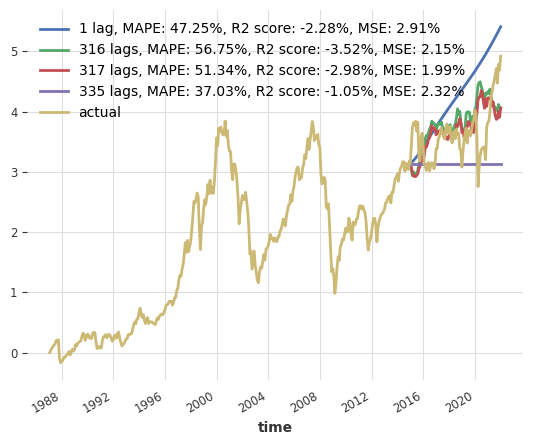

In [93]:
# plot the elastic net forecast with 1, 316, 317 and 335 lags and label with MAPE rounded to 2 decimals and R2 score rounded to 2 decimals and MSE rounded to 2 decimals
elastic_forecast_1['STOXX Europe 600'].plot(label='1 lag, MAPE: ' + str(round(mape(test, elastic_forecast_1), 2)) + '%, R2 score: ' + str(round(r2_score(test, elastic_forecast_1), 2)) + '%, MSE: ' + str(round(mse(test, elastic_forecast_1), 2)) + '%')
elastic_forecast_316['STOXX Europe 600'].plot(label='316 lags, MAPE: ' + str(round(mape(test, elastic_forecast_316), 2)) + '%, R2 score: ' + str(round(r2_score(test, elastic_forecast_316), 2)) + '%, MSE: ' + str(round(mse(test, elastic_forecast_316), 2)) + '%')
elastic_forecast_317['STOXX Europe 600'].plot(label='317 lags, MAPE: ' + str(round(mape(test, elastic_forecast_317), 2)) + '%, R2 score: ' + str(round(r2_score(test, elastic_forecast_317), 2)) + '%, MSE: ' + str(round(mse(test, elastic_forecast_317), 2)) + '%')
elastic_forecast_335['STOXX Europe 600'].plot(label='335 lags, MAPE: ' + str(round(mape(test, elastic_forecast_335), 2)) + '%, R2 score: ' + str(round(r2_score(test, elastic_forecast_335), 2)) + '%, MSE: ' + str(round(mse(test, elastic_forecast_335), 2)) + '%')

# rewrite to see only one line
cum_returns['STOXX Europe 600'].plot(label='actual')

In [94]:
# first elastic net regression model with 1 lag
hf1_elastic_net_regression = elastic_model_1.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

# second elastic net regression model with 316 lags
hf2_elastic_net_regression = elastic_model_316.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

# third elastic net regression model with 317 lags
#hf3_elastic_net_regression = elastic_model_317.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

# fourth elastic net regression model with 335 lags
#hf4_elastic_net_regression = elastic_model_335.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

  0%|          | 0/169 [00:00<?, ?it/s]

`start` value `0.6` corresponding to timestamp `2008-01-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2013-08-01 00:00:00. To hide these warnings, set `show_warnings=False`.


  0%|          | 0/102 [00:00<?, ?it/s]

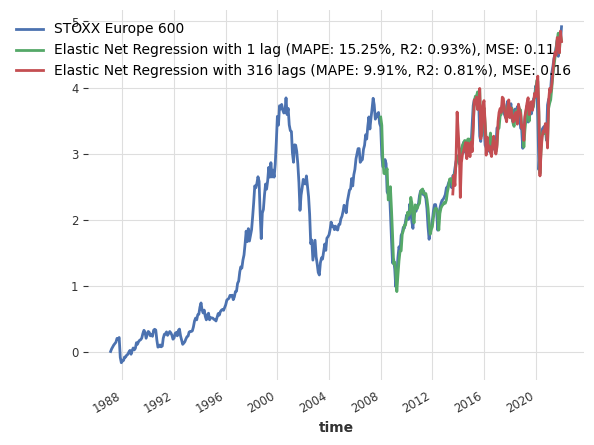

In [95]:
# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
hf1_elastic_net_regression['STOXX Europe 600'].plot(label='Elastic Net Regression with 1 lag (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf1_elastic_net_regression, cum_returns), r2_score(hf1_elastic_net_regression, cum_returns), mse(hf1_elastic_net_regression, cum_returns)))
hf2_elastic_net_regression['STOXX Europe 600'].plot(label='Elastic Net Regression with 316 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf2_elastic_net_regression, cum_returns), r2_score(hf2_elastic_net_regression, cum_returns), mse(hf2_elastic_net_regression, cum_returns)))
#hf3_elastic_net_regression['STOXX Europe 600'].plot(label='Elastic Net Regression with 317 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf3_elastic_net_regression, cum_returns), r2_score(hf3_elastic_net_regression, cum_returns), mse(hf3_elastic_net_regression, cum_returns)))
#hf4_elastic_net_regression['STOXX Europe 600'].plot(label='Elastic Net Regression with 335 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf4_elastic_net_regression, cum_returns), r2_score(hf4_elastic_net_regression, cum_returns), mse(hf4_elastic_net_regression, cum_returns)))

#### Portfolio

In [96]:
# change type of the elastic net forecasts to a pandas dataframe
elastic_forecast_1 = elastic_forecast_1.pd_dataframe()
elastic_forecast_316 = elastic_forecast_316.pd_dataframe()

In [97]:
# perform mean-variance optimization
mu_elastic_net_regression_1 = expected_returns.mean_historical_return(elastic_forecast_1)
S_elastic_net_regression_1 = risk_models.sample_cov(elastic_forecast_1)

mu_elastic_net_regression_316 = expected_returns.mean_historical_return(elastic_forecast_316)
S_elastic_net_regression_316 = risk_models.sample_cov(elastic_forecast_316)

In [98]:
# optimize for maximal Sharpe ratio
ef_elastic_net_regression_1 = EfficientFrontier(mu_elastic_net_regression_1, S_elastic_net_regression_1)
ef_elastic_net_regression_1.add_constraint(lambda w: w[0] == 0)
weights_enr_1 = ef_elastic_net_regression_1.max_sharpe()

ef_elastic_net_regression_316 = EfficientFrontier(mu_elastic_net_regression_316, S_elastic_net_regression_316)
ef_elastic_net_regression_316.add_constraint(lambda w: w[0] == 0)
weights_enr_316 = ef_elastic_net_regression_316.max_sharpe()

In [99]:
# print the weights in a table and round them to 4 decimals
print('Weights for Elastic Net regression with 1 lag: ' + str(np.round(pd.Series(weights_enr_1), 3)))
print('Weights for Elastic Net regression with 316 lags: ' + str(np.round(pd.Series(weights_enr_316), 3)))

Weights for Elastic Net regression with 1 lag: STOXX Europe 600               0.000
STOXX Europe Banks             0.000
STOXX Europe Financials        0.000
STOXX Europe Auto & Parts      0.000
STOXX Europe Insurance         0.000
STOXX Europe Technology        0.023
STOXX Europe Utilities         0.000
STOXX Europe Chemicals         0.000
STOXX Europe Basic Resource    0.108
STOXX Europe Con & Mat         0.000
STOXX Europe Health Care       0.869
STOXX Europe Inds Gds & Svs    0.000
STOXX Europe Media             0.000
STOXX Europe Telecoms          0.000
dtype: float64
Weights for Elastic Net regression with 316 lags: STOXX Europe 600               0.000
STOXX Europe Banks             0.000
STOXX Europe Financials        0.000
STOXX Europe Auto & Parts      0.111
STOXX Europe Insurance         0.886
STOXX Europe Technology        0.000
STOXX Europe Utilities         0.000
STOXX Europe Chemicals         0.000
STOXX Europe Basic Resource    0.000
STOXX Europe Con & Mat         0.000


In [100]:
# compute the returns of elastic net regression portfolio
enr_returns_1 = (cum_returns_portfolio * weights_enr_1).sum(axis=1)
enr_returns_316 = (cum_returns_portfolio * weights_enr_316).sum(axis=1)

portfolio_returns['Elastic_Net_1'] = enr_returns_1
portfolio_returns['Elastic_Net_316'] = enr_returns_316

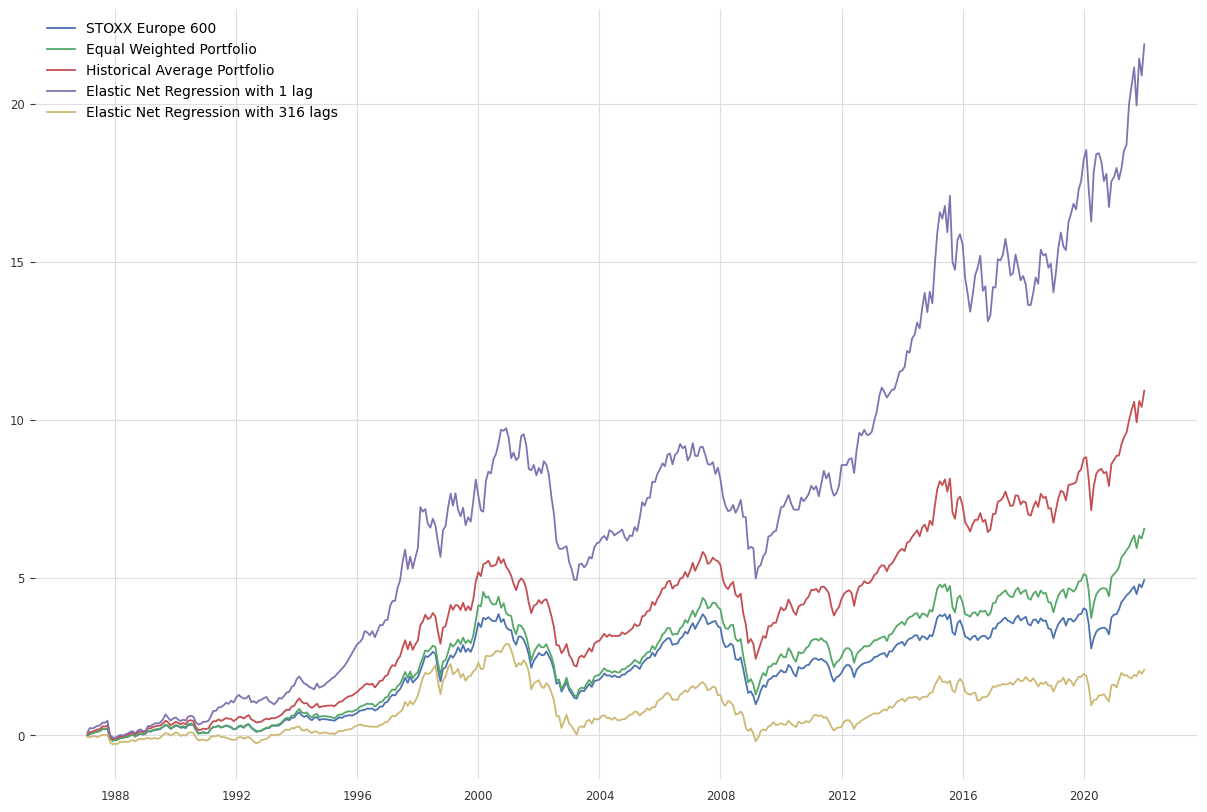

In [101]:
# plot the cumulative returns of the benchmark and the elastic net regression portfolio
plt.figure(figsize=(15,10))
plt.plot(cum_returns_portfolio['STOXX Europe 600'], label='STOXX Europe 600')
plt.plot(portfolio_returns['equal_weighted'], label='Equal Weighted Portfolio')
plt.plot(portfolio_returns['historical_average'], label='Historical Average Portfolio')
plt.plot(portfolio_returns['Elastic_Net_1'], label='Elastic Net Regression with 1 lag')
plt.plot(portfolio_returns['Elastic_Net_316'], label='Elastic Net Regression with 316 lags')
plt.legend(loc='upper left')
plt.show();

In [102]:
# show the last value of each portfolio and round it to 2 decimal places
print('Last value of the STOXX Europe 600: ' + str(np.round(cum_returns_portfolio['STOXX Europe 600'].iloc[-1], 2)) + '%')
print('Last value of the equal weighted portfolio: ' + str(np.round(portfolio_returns['equal_weighted'].iloc[-1], 2)) + '%')
print('Last value of the historical average portfolio: ' + str(np.round(portfolio_returns['historical_average'].iloc[-1], 2)) + '%')
print('Last value of the ridge regression portfolio with 1 lag: ' + str(np.round(portfolio_returns['ridge_regression_1'].iloc[-1], 12)) + '%')
print('Last value of the ridge regression portfolio with 316 lags: ' + str(np.round(portfolio_returns['ridge_regression_316'].iloc[-1], 5)) + '%')
# also for the linear regression portfolio
print('Last value of the linear regression portfolio: ' + str(np.round(portfolio_returns['linear_regression_1'].iloc[-1], 12)) + '%')
print('Last value of the linear regression portfolio: ' + str(np.round(portfolio_returns['linear_regression_316'].iloc[-1], 5)) + '%')
# also for the lasso regression portfolio
print('Last value of the lasso regression portfolio: ' + str(np.round(portfolio_returns['lasso_regression_1'].iloc[-1], 2)) + '%')
print('Last value of the lasso regression portfolio: ' + str(np.round(portfolio_returns['lasso_regression_316'].iloc[-1], 2)) + '%')
# also for the elastic net regression portfolio
print('Last value of the elastic net regression portfolio with 1 lag: ' + str(np.round(portfolio_returns['Elastic_Net_1'].iloc[-1], 2)) + '%')
print('Last value of the elastic net regression portfolio with 316 lags: ' + str(np.round(portfolio_returns['Elastic_Net_316'].iloc[-1], 2)) + '%')

Last value of the STOXX Europe 600: 4.92%
Last value of the equal weighted portfolio: 6.54%
Last value of the historical average portfolio: 10.91%
Last value of the ridge regression portfolio with 1 lag: 24.096923076923%
Last value of the ridge regression portfolio with 316 lags: 7.34664%
Last value of the linear regression portfolio: 17.049795703909%
Last value of the linear regression portfolio: 7.34673%
Last value of the lasso regression portfolio: 21.88%
Last value of the lasso regression portfolio: 2.08%
Last value of the elastic net regression portfolio with 1 lag: 21.88%
Last value of the elastic net regression portfolio with 316 lags: 2.08%


#### Plots Portfolio Analysis

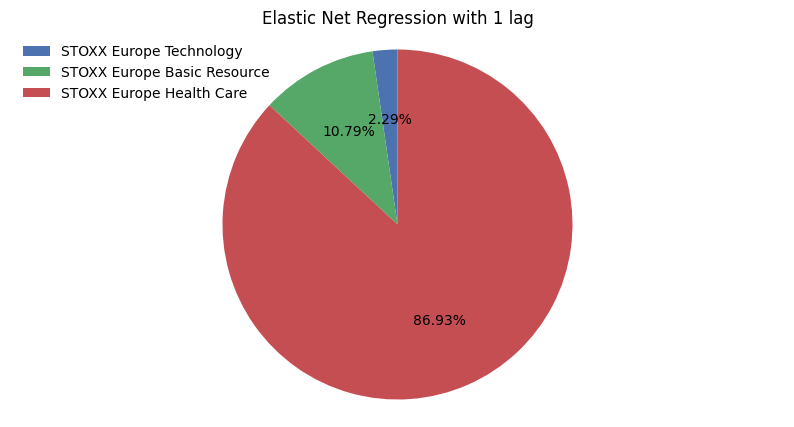

In [103]:
generate_pie_chart(weights_enr_1, 'Elastic Net Regression with 1 lag')

Weights:
                 STOXX Europe Technology  STOXX Europe Basic Resource  STOXX Europe Health Care     Sum
Max Sharpe                        2.29%                       10.79%                    86.93% 100.00%
Min Volatility                    2.20%                       10.48%                    87.32% 100.00%

Performance:
                 Return  Volatility
Max Sharpe      21.88%       5.44%
Min Volatility  21.95%       5.46%


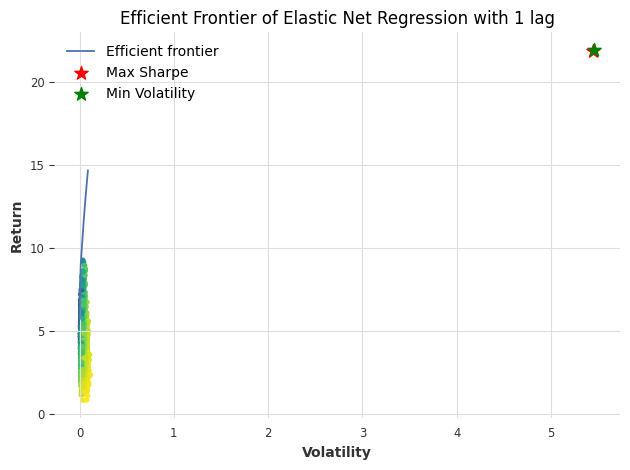

In [104]:
plot_efficient_frontier(mu_elastic_net_regression_1, S_elastic_net_regression_1, cum_returns_portfolio, 'Efficient Frontier of Elastic Net Regression with 1 lag')

### Bridge Regression

In [105]:
"""hyperparameter_bridge = {
    "lags": list(range(1,336, 10)),
    'model': [
        sklearn.linear_model.LassoLarsCV(cv=c, n_jobs=-1) 
        for c in np.arange(2, 13, 1)
    ]
}"""

'hyperparameter_bridge = {\n    "lags": list(range(1,336, 10)),\n    \'model\': [\n        sklearn.linear_model.LassoLarsCV(cv=c, n_jobs=-1) \n        for c in np.arange(2, 13, 1)\n    ]\n}'

In [106]:
"""bridge_regression_tune = RegressionModel(
    lags= hyperparameter_bridge['lags'][0],
    model=sklearn.linear_model.LassoLarsCV(cv=0, n_jobs=-1)
)"""

"bridge_regression_tune = RegressionModel(\n    lags= hyperparameter_bridge['lags'][0],\n    model=sklearn.linear_model.LassoLarsCV(cv=0, n_jobs=-1)\n)"

In [107]:
"""tuning_bridge = bridge_regression_tune.gridsearch(
    parameters= hyperparameter_bridge,
    series= train,
    val_series= test,
    start= 0.1,
    #metric= mape,
    n_jobs= -1,
    verbose= True
)"""

'tuning_bridge = bridge_regression_tune.gridsearch(\n    parameters= hyperparameter_bridge,\n    series= train,\n    val_series= test,\n    start= 0.1,\n    #metric= mape,\n    n_jobs= -1,\n    verbose= True\n)'

In [108]:
"""best_model, best_params = tuning_bridge[0], tuning_bridge[1]
# print the best model parameters
best_model.model_params"""

'best_model, best_params = tuning_bridge[0], tuning_bridge[1]\n# print the best model parameters\nbest_model.model_params'

In [109]:
# I have tested the model with different lags, which have shown the best results for mape and mse
# bridge regression model with 1 lag of STOXX Europe 600
bridge_regression_1 = RegressionModel(lags= 1, model=sklearn.linear_model.LassoLarsCV(cv=2, n_jobs=-1))
bridge_regression_1.fit(train)
bridge_forecast_1 = bridge_regression_1.predict(len(test))

# bridge regression model with 316 lags of STOXX Europe 600
bridge_regression_316 = RegressionModel(lags= 316, model=sklearn.linear_model.LassoLarsCV(cv=2, n_jobs=-1))
bridge_regression_316.fit(train)
bridge_forecast_316 = bridge_regression_316.predict(len(test))

# bridge regression model with 317 lags of STOXX Europe 600
bridge_regression_317 = RegressionModel(lags= 317, model=sklearn.linear_model.LassoLarsCV(cv=2, n_jobs=-1))
bridge_regression_317.fit(train)
bridge_forecast_317 = bridge_regression_317.predict(len(test))

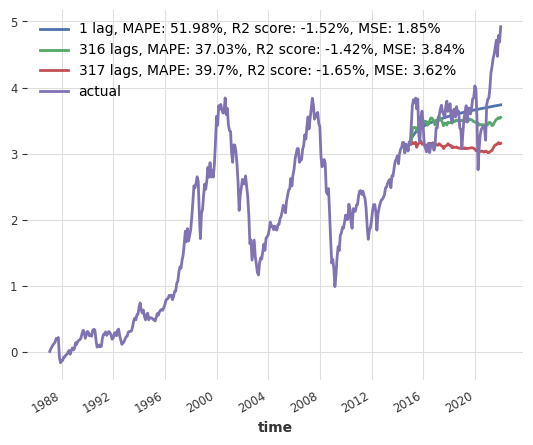

In [110]:
# plot the bridge forecast with 1, 316, 317  lags and label with MAPE rounded to 2 decimals and R2 score rounded to 2 decimals and MSE rounded to 2 decimals
bridge_forecast_1['STOXX Europe 600'].plot(label='1 lag, MAPE: ' + str(round(mape(test, bridge_forecast_1), 2)) + '%, R2 score: ' + str(round(r2_score(test, bridge_forecast_1), 2)) + '%, MSE: ' + str(round(mse(test, bridge_forecast_1), 2)) + '%')
bridge_forecast_316['STOXX Europe 600'].plot(label='316 lags, MAPE: ' + str(round(mape(test, bridge_forecast_316), 2)) + '%, R2 score: ' + str(round(r2_score(test, bridge_forecast_316), 2)) + '%, MSE: ' + str(round(mse(test, bridge_forecast_316), 2)) + '%')
bridge_forecast_317['STOXX Europe 600'].plot(label='317 lags, MAPE: ' + str(round(mape(test, bridge_forecast_317), 2)) + '%, R2 score: ' + str(round(r2_score(test, bridge_forecast_317), 2)) + '%, MSE: ' + str(round(mse(test, bridge_forecast_317), 2)) + '%')

# rewrite to see only one line
cum_returns['STOXX Europe 600'].plot(label='actual')

In [111]:
# first bridge regression model with 1 lag
hf1_bridge_regression = bridge_regression_1.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)
# second bridge regression model with 316 lags
#hf2_bridge_regression = bridge_regression_316.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)
# third bridge regression model with 317 lags
#hf3_bridge_regression = bridge_regression_317.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

  0%|          | 0/169 [00:00<?, ?it/s]

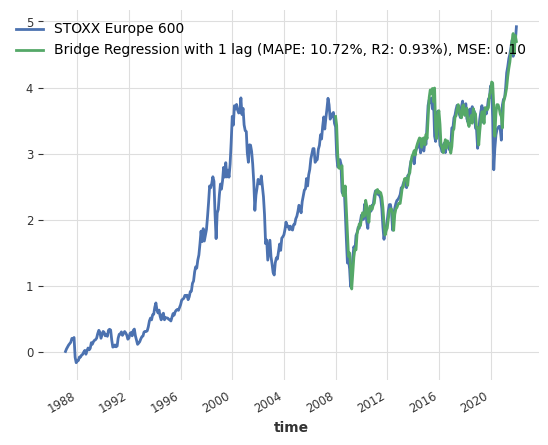

In [112]:
# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
hf1_bridge_regression['STOXX Europe 600'].plot(label='Bridge Regression with 1 lag (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf1_bridge_regression, cum_returns), r2_score(hf1_bridge_regression, cum_returns), mse(hf1_bridge_regression, cum_returns)))
#hf2_bridge_regression['STOXX Europe 600'].plot(label='Bridge Regression with 316 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf2_bridge_regression, cum_returns), r2_score(hf2_bridge_regression, cum_returns), mse(hf2_bridge_regression, cum_returns)))
#hf3_bridge_regression['STOXX Europe 600'].plot(label='Bridge Regression with 317 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf3_bridge_regression, cum_returns), r2_score(hf3_bridge_regression, cum_returns), mse(hf3_bridge_regression, cum_returns)))
#hf4_bridge_regression['STOXX Europe 600'].plot(label='Bridge Regression with 335 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf4_bridge_regression, cum_returns), r2_score(hf4_bridge_regression, cum_returns), mse(hf4_bridge_regression, cum_returns)))

#### Portfolio

In [113]:
# change the type of the bridge forecast to pandas dataframe
bridge_forecast_1 = bridge_forecast_1.pd_dataframe()

In [114]:
# perform mean-variance optimization
mu_bridge_regression_1 = expected_returns.mean_historical_return(bridge_forecast_1)
S_bridge_regression_1 = risk_models.sample_cov(bridge_forecast_1)

In [115]:
# optimize for maximal Sharpe ratio
ef_bridge_regression_1 = EfficientFrontier(mu_bridge_regression_1, S_bridge_regression_1)
ef_bridge_regression_1.add_constraint(lambda w: w[0] == 0)
weights_br_1 = ef_bridge_regression_1.max_sharpe()

In [116]:
# print the weights in a table and round them to 4 decimals
print('Weights for Bridge regression with 1 lag: ' + str(np.round(pd.Series(weights_br_1), 3)))

Weights for Bridge regression with 1 lag: STOXX Europe 600               0.000
STOXX Europe Banks             0.000
STOXX Europe Financials        0.000
STOXX Europe Auto & Parts      0.000
STOXX Europe Insurance         0.000
STOXX Europe Technology        0.000
STOXX Europe Utilities         0.000
STOXX Europe Chemicals         0.000
STOXX Europe Basic Resource    0.000
STOXX Europe Con & Mat         0.018
STOXX Europe Health Care       0.982
STOXX Europe Inds Gds & Svs    0.000
STOXX Europe Media             0.000
STOXX Europe Telecoms          0.000
dtype: float64


In [117]:
# compute the returns of bridge regression portfolio
br_returns_1 = (cum_returns_portfolio * weights_br_1).sum(axis=1)

portfolio_returns['bridge_regression_1'] = br_returns_1

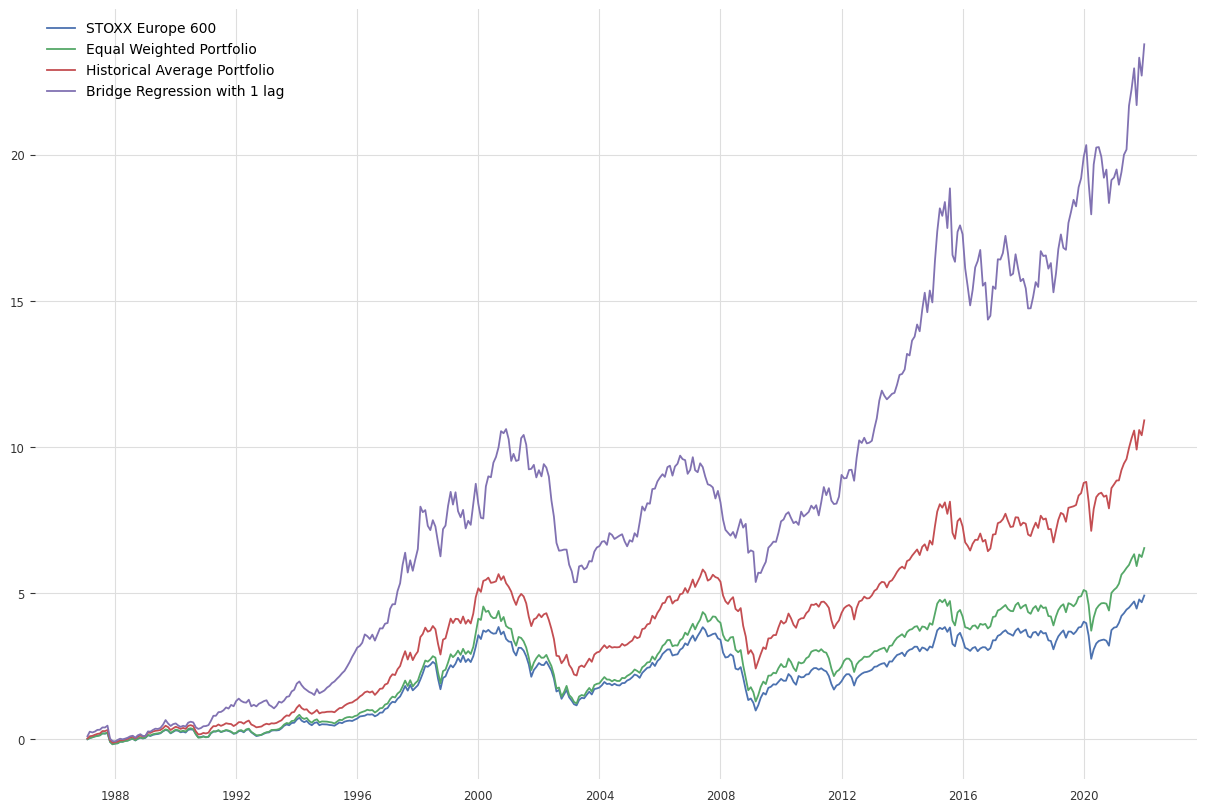

In [118]:
# plot the cumulative returns of the benchmark and the bridge regression portfolio
plt.figure(figsize=(15,10))
plt.plot(cum_returns_portfolio['STOXX Europe 600'], label='STOXX Europe 600')
plt.plot(portfolio_returns['equal_weighted'], label='Equal Weighted Portfolio')
plt.plot(portfolio_returns['historical_average'], label='Historical Average Portfolio')
plt.plot(portfolio_returns['bridge_regression_1'], label='Bridge Regression with 1 lag')
plt.legend(loc='upper left')
plt.show();

#### Plots Portfolio Analysis

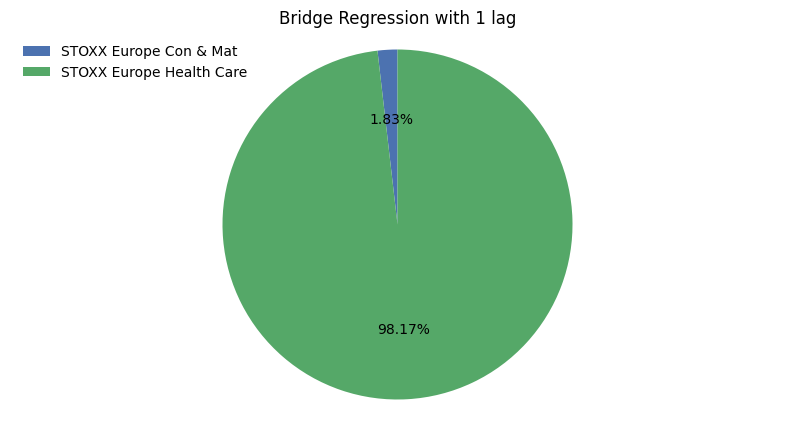

In [119]:
generate_pie_chart(weights_br_1, 'Bridge Regression with 1 lag')

Weights:
                 STOXX Europe Auto & Parts  STOXX Europe Utilities  STOXX Europe Con & Mat  STOXX Europe Health Care     Sum
Max Sharpe                          0.00%                   0.00%                   1.83%                    98.17% 100.00%
Min Volatility                      0.24%                   2.06%                   2.67%                    95.03% 100.00%

Performance:
                 Return  Volatility
Max Sharpe      23.78%       5.95%
Min Volatility  23.19%       5.80%


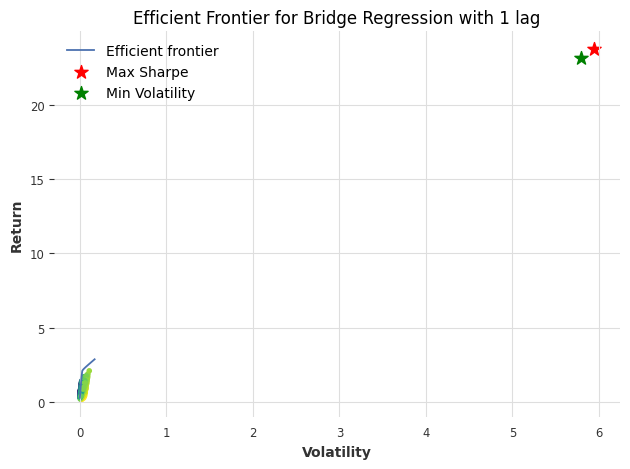

In [120]:
plot_efficient_frontier(mu_bridge_regression_1, S_bridge_regression_1, cum_returns_portfolio, 'Efficient Frontier for Bridge Regression with 1 lag')

# Outcome Shrinkage Portfolio Building

First generate a graph showing all models compared to their benchmarks & then create a table showing the numerical results.

In [121]:
portfolio_returns.tail(5)

component,equal_weighted,historical_average,Bayesian Regression,linear_regression_1,linear_regression_316,ridge_regression_1,ridge_regression_316,lasso_regression_1,lasso_regression_316,Elastic_Net_1,Elastic_Net_316,bridge_regression_1
time,,,,,,,,,,,,
2021-09-01,6.334322,10.565259,21.757793,16.437078,7.241788,23.264545,7.241703,21.147879,1.920520,21.147879,1.920520,22.959692
2021-10-01,5.926514,9.912039,20.570190,15.535738,6.504470,21.991305,6.504393,19.946396,1.875364,19.946396,1.875364,21.698781
2021-11-01,6.322933,10.583310,22.082632,16.719975,6.839192,23.637809,6.839111,21.427089,2.045217,21.427089,2.045217,23.323187
2021-12-01,6.237121,10.402550,21.532173,16.281709,6.914258,23.011935,6.914176,20.892168,1.949463,20.892168,1.949463,22.707336
2022-01-01,6.544394,10.913366,22.553606,17.049796,7.346731,24.096923,7.346643,21.880713,2.078423,21.880713,2.078423,23.780296


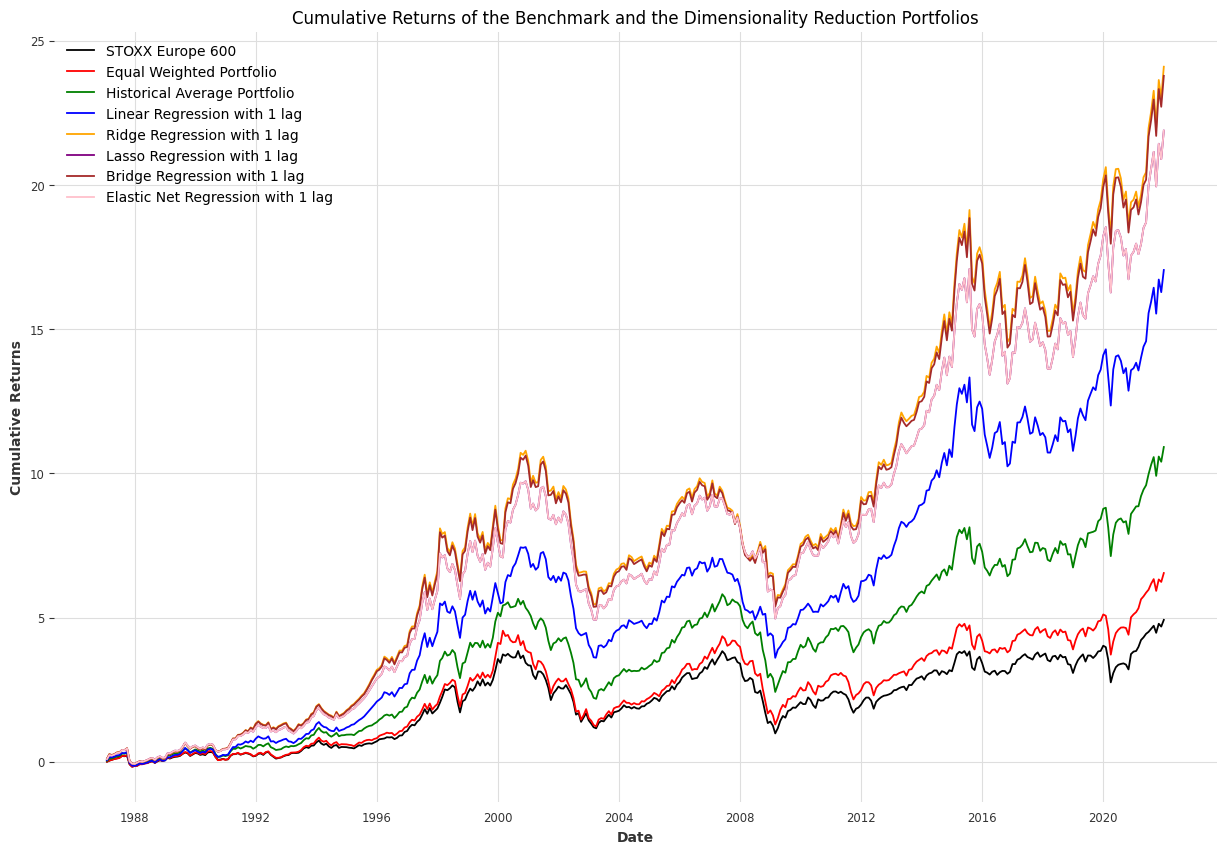

In [122]:
# plot all the cumulative returns
plt.figure(figsize=(15,10))
plt.plot(cum_returns_portfolio['STOXX Europe 600'], color= 'black', label='STOXX Europe 600')
plt.plot(portfolio_returns['equal_weighted'], color= 'red', label='Equal Weighted Portfolio')
plt.plot(portfolio_returns['historical_average'], color= 'green', label='Historical Average Portfolio')
# plot linear regression with 1 lag
plt.plot(portfolio_returns['linear_regression_1'], color= 'blue', label='Linear Regression with 1 lag')
# plot ridge regression with 1 lag
plt.plot(portfolio_returns['ridge_regression_1'], color= 'orange', label='Ridge Regression with 1 lag')
# plot lasso regression with 1 lag
plt.plot(portfolio_returns['lasso_regression_1'], color= 'purple', label='Lasso Regression with 1 lag')
# plot bridge regression with 1 lag
plt.plot(portfolio_returns['bridge_regression_1'], color= 'brown', label='Bridge Regression with 1 lag')
# plot elastic net regression with 1 lag
plt.plot(portfolio_returns['Elastic_Net_1'], color= 'pink', label='Elastic Net Regression with 1 lag')
plt.legend(loc='upper left')
# set the title of the plot
plt.title('Cumulative Returns of the Benchmark and the Dimensionality Reduction Portfolios')
# set the x-axis label
plt.xlabel('Date')
# set the y-axis label
plt.ylabel('Cumulative Returns')
# show the plot
plt.show();

In [123]:
import tabulate

In [124]:
import pandas as pd

# Create a dictionary with the data
data = {
    'Portfolio': ['STOXX Europe 600', 'Equal Weighted Portfolio', 'Historical Average Portfolio', 'Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Elastic Net Regression', 'Bridge Regression'],
    '1 Lag': [cum_returns_portfolio['STOXX Europe 600'].tail(1).values[0], 
              portfolio_returns['equal_weighted'].tail(1).values[0], 
              portfolio_returns['historical_average'].tail(1).values[0],
              portfolio_returns['linear_regression_1'].tail(1).values[0],
                portfolio_returns['ridge_regression_1'].tail(1).values[0],
                portfolio_returns['lasso_regression_1'].tail(1).values[0],
                portfolio_returns['Elastic_Net_1'].tail(1).values[0],
                portfolio_returns['bridge_regression_1'].tail(1).values[0]],
    '316 Lags': [cum_returns_portfolio['STOXX Europe 600'].tail(1).values[0], 
                 portfolio_returns['equal_weighted'].tail(1).values[0], 
                 portfolio_returns['historical_average'].tail(1).values[0],
                   portfolio_returns['linear_regression_316'].tail(1).values[0],
                   portfolio_returns['ridge_regression_316'].tail(1).values[0],
                  portfolio_returns['lasso_regression_316'].tail(1).values[0],
                  portfolio_returns['Elastic_Net_316'].tail(1).values[0],
                  None]
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Divide the values by 100 to get the percentage
df[['1 Lag', '316 Lags']] = df[['1 Lag', '316 Lags']].div(100)

# Set the index of the DataFrame to be the Portfolio column
df.set_index('Portfolio', inplace=True)

# Format the DataFrame to display the values as percentages
df.style.format("{:.3%}", subset=['1 Lag', '316 Lags'])

,1 Lag,316 Lags
Portfolio,,
STOXX Europe 600,4.921%,4.921%
Equal Weighted Portfolio,6.544%,6.544%
Historical Average Portfolio,10.913%,10.913%
Linear Regression,17.050%,7.347%
Ridge Regression,24.097%,7.347%
Lasso Regression,21.881%,2.078%
Elastic Net Regression,21.881%,2.078%
Bridge Regression,23.780%,nan%


In [125]:
# print this customized table to latex including the percentage sign and multiply the values by 100
print(df.to_latex(float_format="%.3f", formatters={"1 Lag": "{:.2%}".format, "316 Lags": "{:.2%}".format}))

\begin{tabular}{lrr}
\toprule
{} &  1 Lag & 316 Lags \\
Portfolio                    &        &          \\
\midrule
STOXX Europe 600             &  4.92\% &    4.92\% \\
Equal Weighted Portfolio     &  6.54\% &    6.54\% \\
Historical Average Portfolio & 10.91\% &   10.91\% \\
Linear Regression            & 17.05\% &    7.35\% \\
Ridge Regression             & 24.10\% &    7.35\% \\
Lasso Regression             & 21.88\% &    2.08\% \\
Elastic Net Regression       & 21.88\% &    2.08\% \\
Bridge Regression            & 23.78\% &      NaN \\
\bottomrule
\end{tabular}



In [126]:
# convert portfolio returns as pandas.core.Series to a darts.timeseries.TimeSeries
# save portfolio returns as a csv file
portfolio_returns.to_csv('data/portfolio_returns_shrinkage.csv', index=True, header=True)

# get portfolio returns from csv file as TimeSeries
portfolio_returns_timeseries = TimeSeries.from_csv('data/portfolio_returns_shrinkage.csv', index_col=0, parse_dates=True)

In [127]:
# print mape for equal weighted portfolio
mape(portfolio_returns_timeseries['equal_weighted'], cum_returns['STOXX Europe 600'])

14.298511472922698

In [134]:
# create a table that includes the mape, mse, and r2 score for each portfolio
data = {
    'Portfolio': ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Elastic Net', 'Bayesian Regression'], 
    'MAPE': [mape(hf1_linear_regression, cum_returns), 
             mape(hf1_ridge_regression, cum_returns), 
             mape(hf1_lasso_regression, cum_returns), 
             mape(hf1_elastic_net_regression, cum_returns), 
             mape(hf1_bayesian, cum_returns)],
    'MSE': [mse(hf1_linear_regression, cum_returns),
            mse(hf1_ridge_regression, cum_returns),
            mse(hf1_lasso_regression, cum_returns),
            mse(hf1_elastic_net_regression, cum_returns),
            mse(hf1_bayesian, cum_returns)],
            'MAE': [mae(hf1_linear_regression, cum_returns),
                mae(hf1_ridge_regression, cum_returns),
                mae(hf1_lasso_regression, cum_returns),
                mae(hf1_elastic_net_regression, cum_returns),
                mae(hf1_bayesian, cum_returns)],
    'R2 Score': [r2_score(hf1_linear_regression, cum_returns),
                 r2_score(hf1_ridge_regression, cum_returns),
                 r2_score(hf1_lasso_regression, cum_returns),
                 r2_score(hf1_elastic_net_regression, cum_returns),
                 r2_score(hf1_bayesian, cum_returns)]
}

In [136]:
# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

In [137]:
# Set the index of the DataFrame to be the Portfolio column
df.set_index('Portfolio', inplace=True)

# Divide the values by 100 to get the percentage
df[['MAPE', 'MSE', 'MAE', 'R2 Score']] = df[['MAPE', 'MSE', 'MAE', 'R2 Score']].div(100)

# Format the DataFrame to display the values as percentages
df.style.format("{:.3%}", subset=['MAPE'])

# print this customized table to latex including the percentage sign and multiply the values by 100
print(df.to_latex(float_format="%.3f", formatters={"MAPE": "{:.2%}".format, "MSE": "{:.2%}".format, "MAE": "{:.2%}".format, "R2 Score": "{:.2%}".format}))

\begin{tabular}{lrrrr}
\toprule
{} &   MAPE &   MSE &   MAE & R2 Score \\
Portfolio           &        &       &       &          \\
\midrule
Linear Regression   & 18.71\% & 0.11\% & 0.22\% &    0.92\% \\
Ridge Regression    &  8.25\% & 0.10\% & 0.21\% &    0.91\% \\
Lasso Regression    & 15.25\% & 0.11\% & 0.22\% &    0.93\% \\
Elastic Net         & 15.25\% & 0.11\% & 0.22\% &    0.93\% \\
Bayesian Regression &  8.51\% & 0.10\% & 0.21\% &    0.91\% \\
\bottomrule
\end{tabular}



In [138]:
# save this dataframe as a csv file
df.to_csv('data/evaluation_shrinkage.csv', index=True, header=True)

In [133]:
# create a table that shows the return and the volatility of the max sharpe and min vol portfolios for each model

data = {
    'Portfolio': ['Max Sharpe Portfolio', 'Min Volatility Portfolio'],
 'Linear Regression': [['17.05%', '4.25%'], ['15.25%', '3.78%']],
    'Ridge Regression': [['24.10%', '6.03%'], ['24.10%', '6.03%']],
    'Lasso Regression': [['21.88%', '5.44%'], ['21.95%', '5.46%']],
    'Elastic Net Regression': [['21.88%', '5.44%'], ['21.95%', '5.46%']],
    'Bridge Regression': [['23.78%', '5.95%'], ['23.19%', '5.80%']]
}   

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Set the index of the DataFrame to be the Portfolio column
df.set_index('Portfolio', inplace=True)

# print table
df

,Linear Regression,Ridge Regression,Lasso Regression,Elastic Net Regression,Bridge Regression
Portfolio,,,,,
Max Sharpe Portfolio,"[17.05%, 4.25%]","[24.10%, 6.03%]","[21.88%, 5.44%]","[21.88%, 5.44%]","[23.78%, 5.95%]"
Min Volatility Portfolio,"[15.25%, 3.78%]","[24.10%, 6.03%]","[21.95%, 5.46%]","[21.95%, 5.46%]","[23.19%, 5.80%]"


In [134]:
# generate a table that shows return of benchmark portfolios STOXX Europe 600, equal weighted, and historical average

data = {
    'Portfolio': ['STOXX Europe 600', 'Equal Weighted Portfolio', 'Historical Average Portfolio'],
    'Return': [cum_returns_portfolio['STOXX Europe 600'].tail(1).values[0], 
              portfolio_returns['equal_weighted'].tail(1).values[0], 
              portfolio_returns['historical_average'].tail(1).values[0]],
    'Volatility': [cum_returns_portfolio['STOXX Europe 600'].std(),
                    portfolio_returns['equal_weighted'].std(),
                    portfolio_returns['historical_average'].std()]
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Set the index of the DataFrame to be the Portfolio column
df.set_index('Portfolio', inplace=True)

# divide the values by 100 to get the percentage
df[['Return', 'Volatility']] = df[['Return', 'Volatility']].div(100)

# Format the DataFrame to display the values as percentages with only 2 decimal places
df.style.format("{:.2%}", subset=['Return', 'Volatility'])

,Return,Volatility
Portfolio,,
STOXX Europe 600,4.92%,1.31%
Equal Weighted Portfolio,6.54%,1.63%
Historical Average Portfolio,10.91%,2.67%


In [138]:
# generate a table containing the return and volatility for all models
data = {
    'Portfolio': ['STOXX Europe 600', 'Equal Weighted Portfolio', 'Historical Average Portfolio', 'Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Elastic Net', 'Bayesian Regression'],
    'Return': [cum_returns_portfolio['STOXX Europe 600'].tail(1).values[0], 
              portfolio_returns['equal_weighted'].tail(1).values[0], 
              portfolio_returns['historical_average'].tail(1).values[0],
              portfolio_returns['linear_regression_1'].tail(1).values[0],
                portfolio_returns['ridge_regression_1'].tail(1).values[0],
                portfolio_returns['lasso_regression_1'].tail(1).values[0],
                portfolio_returns['Elastic_Net_1'].tail(1).values[0],
                portfolio_returns['Bayesian Regression'].tail(1).values[0]],
    'Volatility': [cum_returns_portfolio['STOXX Europe 600'].std(),
                    portfolio_returns['equal_weighted'].std(),
                    portfolio_returns['historical_average'].std(),
                    portfolio_returns['linear_regression_1'].std(),
                portfolio_returns['ridge_regression_1'].std(),
                portfolio_returns['lasso_regression_1'].std(),
                portfolio_returns['Elastic_Net_1'].std(),
                portfolio_returns['Bayesian Regression'].std()]
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Set the index of the DataFrame to be the Portfolio column
df.set_index('Portfolio', inplace=True)

# divide the values by 100 to get the percentage
df[['Return', 'Volatility']] = df[['Return', 'Volatility']].div(100)

# Format the DataFrame to display the values as percentages with only 2 decimal places
df.style.format("{:.2%}", subset=['Return', 'Volatility'])

,Return,Volatility
Portfolio,,
STOXX Europe 600,4.92%,1.31%
Equal Weighted Portfolio,6.54%,1.63%
Historical Average Portfolio,10.91%,2.67%
Linear Regression,17.05%,4.25%
Ridge Regression,24.10%,6.03%
Lasso Regression,21.88%,5.44%
Elastic Net,21.88%,5.44%
Bayesian Regression,22.75%,5.68%


In [139]:
# 
print(df.to_latex(float_format="%.3f", formatters={"Return": "{:.2%}".format, "Volatility": "{:.2%}".format}))

\begin{tabular}{lrr}
\toprule
{} & Return & Volatility \\
Portfolio                    &        &            \\
\midrule
STOXX Europe 600             &  4.92\% &      1.31\% \\
Equal Weighted Portfolio     &  6.54\% &      1.63\% \\
Historical Average Portfolio & 10.91\% &      2.67\% \\
Linear Regression            & 17.05\% &      4.25\% \\
Ridge Regression             & 24.10\% &      6.03\% \\
Lasso Regression             & 21.88\% &      5.44\% \\
Elastic Net                  & 21.88\% &      5.44\% \\
Bayesian Regression          & 22.75\% &      5.68\% \\
\bottomrule
\end{tabular}



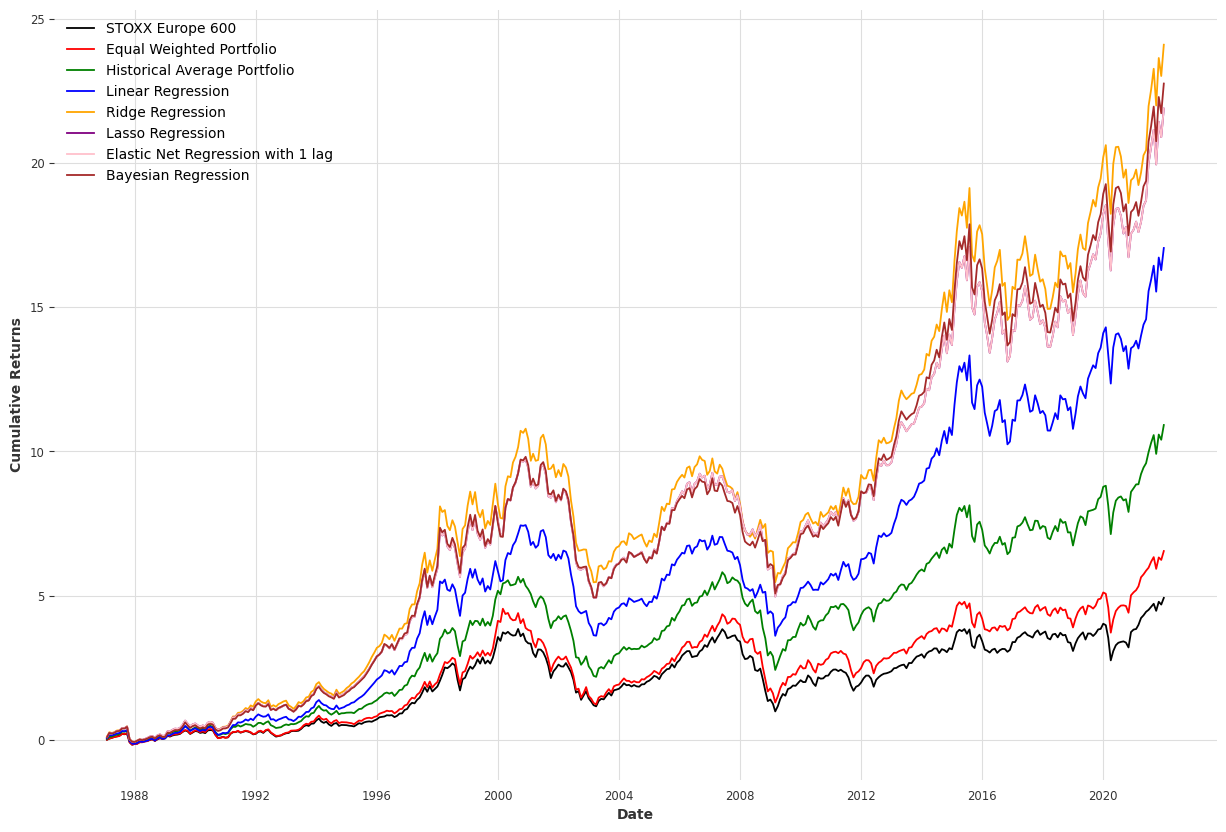

In [140]:
# plot all the cumulative returns
plt.figure(figsize=(15,10))
plt.plot(cum_returns_portfolio['STOXX Europe 600'], color= 'black', label='STOXX Europe 600')
plt.plot(portfolio_returns['equal_weighted'], color= 'red', label='Equal Weighted Portfolio')
plt.plot(portfolio_returns['historical_average'], color= 'green', label='Historical Average Portfolio')
# plot linear regression with 1 lag
plt.plot(portfolio_returns['linear_regression_1'], color= 'blue', label='Linear Regression')
# plot ridge regression with 1 lag
plt.plot(portfolio_returns['ridge_regression_1'], color= 'orange', label='Ridge Regression')
# plot lasso regression with 1 lag
plt.plot(portfolio_returns['lasso_regression_1'], color= 'purple', label='Lasso Regression')
# plot elastic net regression with 1 lag
plt.plot(portfolio_returns['Elastic_Net_1'], color= 'pink', label='Elastic Net Regression with 1 lag')
# plot bayesian regression with 1 lag
plt.plot(portfolio_returns['Bayesian Regression'], color= 'brown', label='Bayesian Regression')
plt.legend(loc='upper left')
# set the x-axis label
plt.xlabel('Date')
# set the y-axis label
plt.ylabel('Cumulative Returns')
# show the plot
plt.show();

In [149]:
# show all stocks of linear regression with 1 lag by percentage
print('Weights for Linear regression with 1 lag: ' + str(np.round(pd.Series(weights_lar_1), 3)))

Weights for Linear regression with 1 lag: STOXX Europe 600               0.000
STOXX Europe Banks             0.000
STOXX Europe Financials        0.000
STOXX Europe Auto & Parts      0.000
STOXX Europe Insurance         0.000
STOXX Europe Technology        0.023
STOXX Europe Utilities         0.000
STOXX Europe Chemicals         0.000
STOXX Europe Basic Resource    0.108
STOXX Europe Con & Mat         0.000
STOXX Europe Health Care       0.869
STOXX Europe Inds Gds & Svs    0.000
STOXX Europe Media             0.000
STOXX Europe Telecoms          0.000
dtype: float64


Weights:
                 STOXX Europe Technology  STOXX Europe Utilities  STOXX Europe Chemicals  STOXX Europe Health Care     Sum
Max Sharpe                        0.17%                   0.00%                  14.16%                    85.67% 100.00%
Min Volatility                    0.12%                   0.63%                  12.12%                    87.12% 100.00%

Performance:
                 Return  Volatility
Max Sharpe      22.55%       5.62%
Min Volatility  22.66%       5.65%


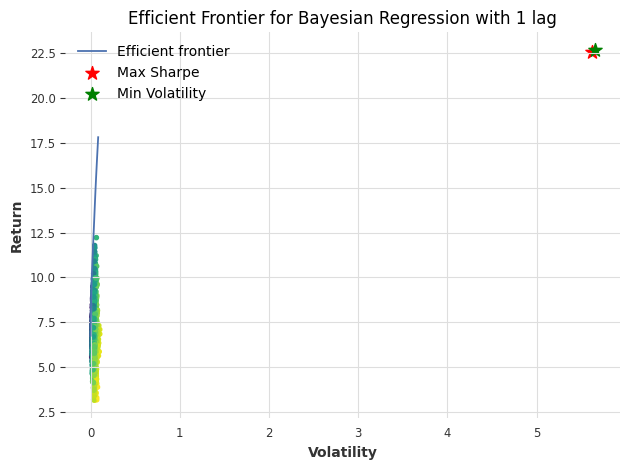

In [155]:
# plot efficient frontier for bayesian regression with 1 lag
plot_efficient_frontier(mu_bayesian_1, S_bayesian_1, cum_returns_portfolio, 'Efficient Frontier for Bayesian Regression with 1 lag')